# Cluster analysis

This notebook serves to visualize clusters extracted from the sales data.
Clustering can be done by any of the following methods:
* Dimentionality reduction followed by clustering using HDBCAN
* Self-Organizing Maps
* Dynamic Time Wapring Distance calculation followed by agglomerative clustering

Each of these techniques can have their clusters analysed in this notebook.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
import umap
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from VisualizationFunctions import plot_by_factor, AnalyzeClusters
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from dynamic_time_warping import Preprocessing
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline

Read in the data: labels, tsfresh features, product level aggregate time series, pivot table.

Scale the data.

In [3]:
agg = pd.read_csv('sku_labels.csv')
df = pd.read_csv('extracted_features.csv')
product_sales = pd.read_csv('aggregate_products.csv')
pivot_table = pd.read_csv('pivot_products.csv')
df.dropna(axis=1, inplace=True)

scale = StandardScaler()
skus = df['id']
df.set_index('id', inplace=True)
X = scale.fit_transform(df)
names = df.columns

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Dimentionality reduction
---
This dimentionality reduction is first of all for visualization of clusters, and also to see if any other groupings emerge from the dataset

In [4]:
print('Running UMAP Dimentionality Reduction...')
um = umap.UMAP(n_neighbors=3, min_dist=0.01)
umaps = um.fit_transform(X)

Running UMAP Dimentionality Reduction...


In [5]:
#Merge umap coordinates onto original df with sku_keys
plot_df = pd.DataFrame(umaps).join(df.reset_index())

#Merge above umap and features table to sku_key and categories
plot_df['sku_key'] = plot_df['id'].astype(int)
agg['sku_key'] = agg['sku_key'].astype(int)
plot_df = plot_df.merge(agg, how='left', on='sku_key')

colors=['b', 'r', 'g', 'y', 'm', 'orange', 'gold', 'skyblue',
        'blue', 'red', 'green', 'yellow', 'brown', 'violet',
        'orchid', 'olive', 'black', 'grey', 'purple',
        'lime', 'darkblue', 'darkred', 'darkgreen',
        'tomato', 'lightgreen', 'lightblue', 'darkorange']

Visualize the distribution of departments along lower dimentional embedding

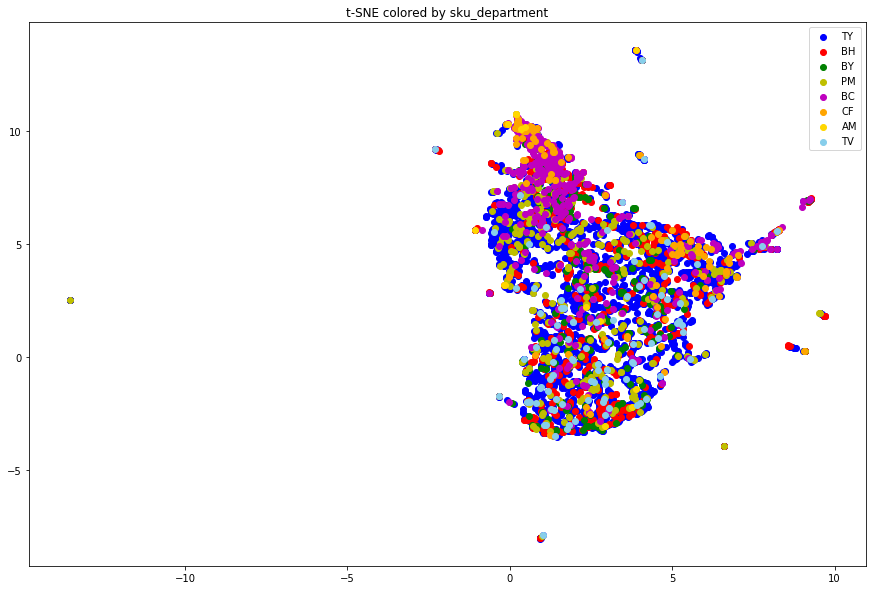

In [6]:
plot_by_factor(plot_df, 'sku_department', colors, showplot=True)

Show distribution of cumulative sales on embedding

In [7]:
sales_df = product_sales.groupby('sku_key').sum().reset_index()[['sku_key', 'sales']]\
.merge(plot_df, on='sku_key')[['sku_key', 'sales', 0,1]]
sales_df['sales_log'] = np.log10(sales_df['sales'])

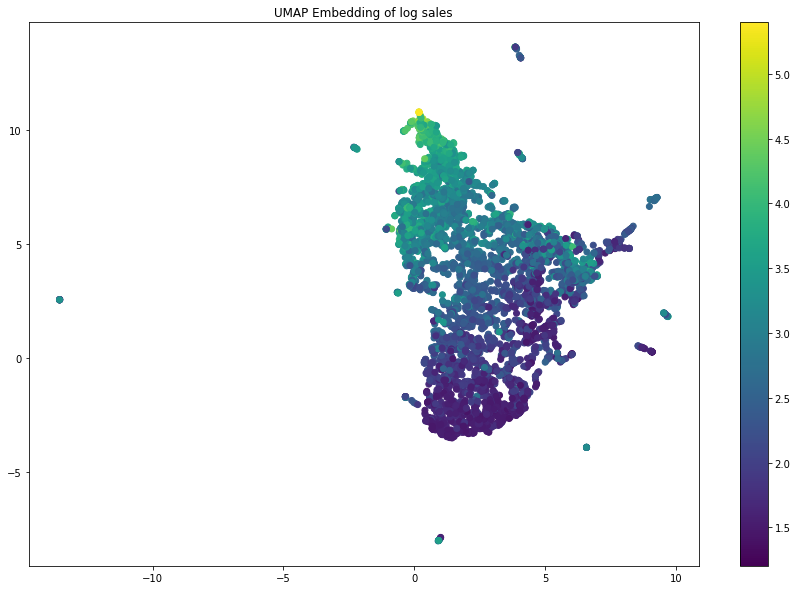

In [8]:
f, ax = plt.subplots(figsize=(15,10))
sc = ax.scatter(sales_df[0], sales_df[1], c=sales_df['sales_log'], cmap='viridis')
plt.colorbar(sc)
ax.set_title('UMAP Embedding of log sales')
plt.show()

# Clustering and cluster analysis

In [9]:
run_cont = ['sales', 'selling_price', 'avg_discount', 'stock_open']
run_cats = ['sku_department', 'sku_subdepartment', 'sku_category', 'sku_subcategory', 'sku_label']

In [11]:
som_clus = pd.read_csv('som_clusters.csv')
som_clus.columns = ['sku_key', 'cluster']

analyze_som = AnalyzeClusters()
df_dict = analyze_som.make_dataset(product_sales, som_clus)

Cluster sizes:


In [12]:
for i, j in df_dict.items():
    print(i, len(j['sku_key'].unique()))

cluster_5 1809
cluster_0 1538
cluster_6 695
cluster_7 107
cluster_4 623
cluster_2 19
cluster_3 653
cluster_1 7


Clusters on embedding

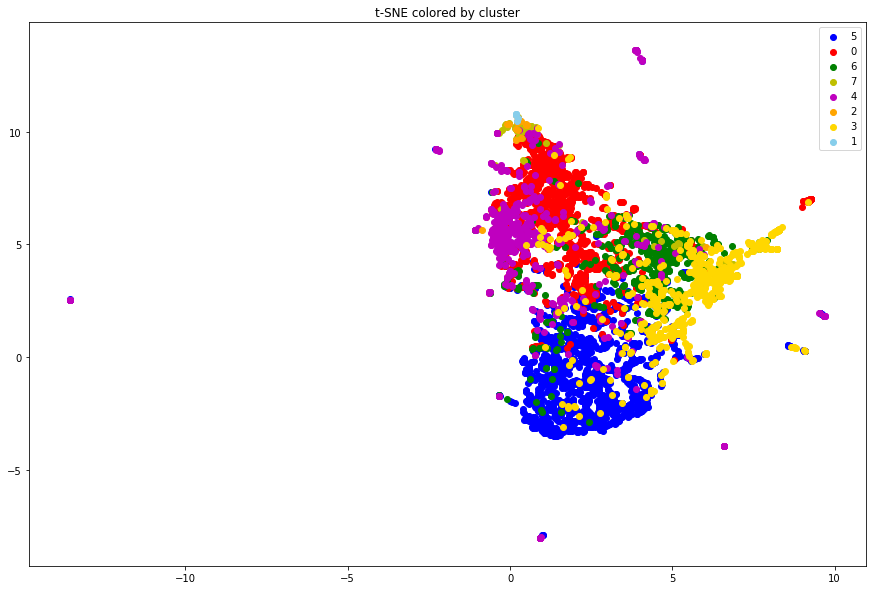

In [13]:
som_tsne = plot_df.merge(som_clus, left_on='id', right_on='sku_key')

plot_by_factor(som_tsne, 'cluster', colors, False)

Have a look at the time series for each of the clusters

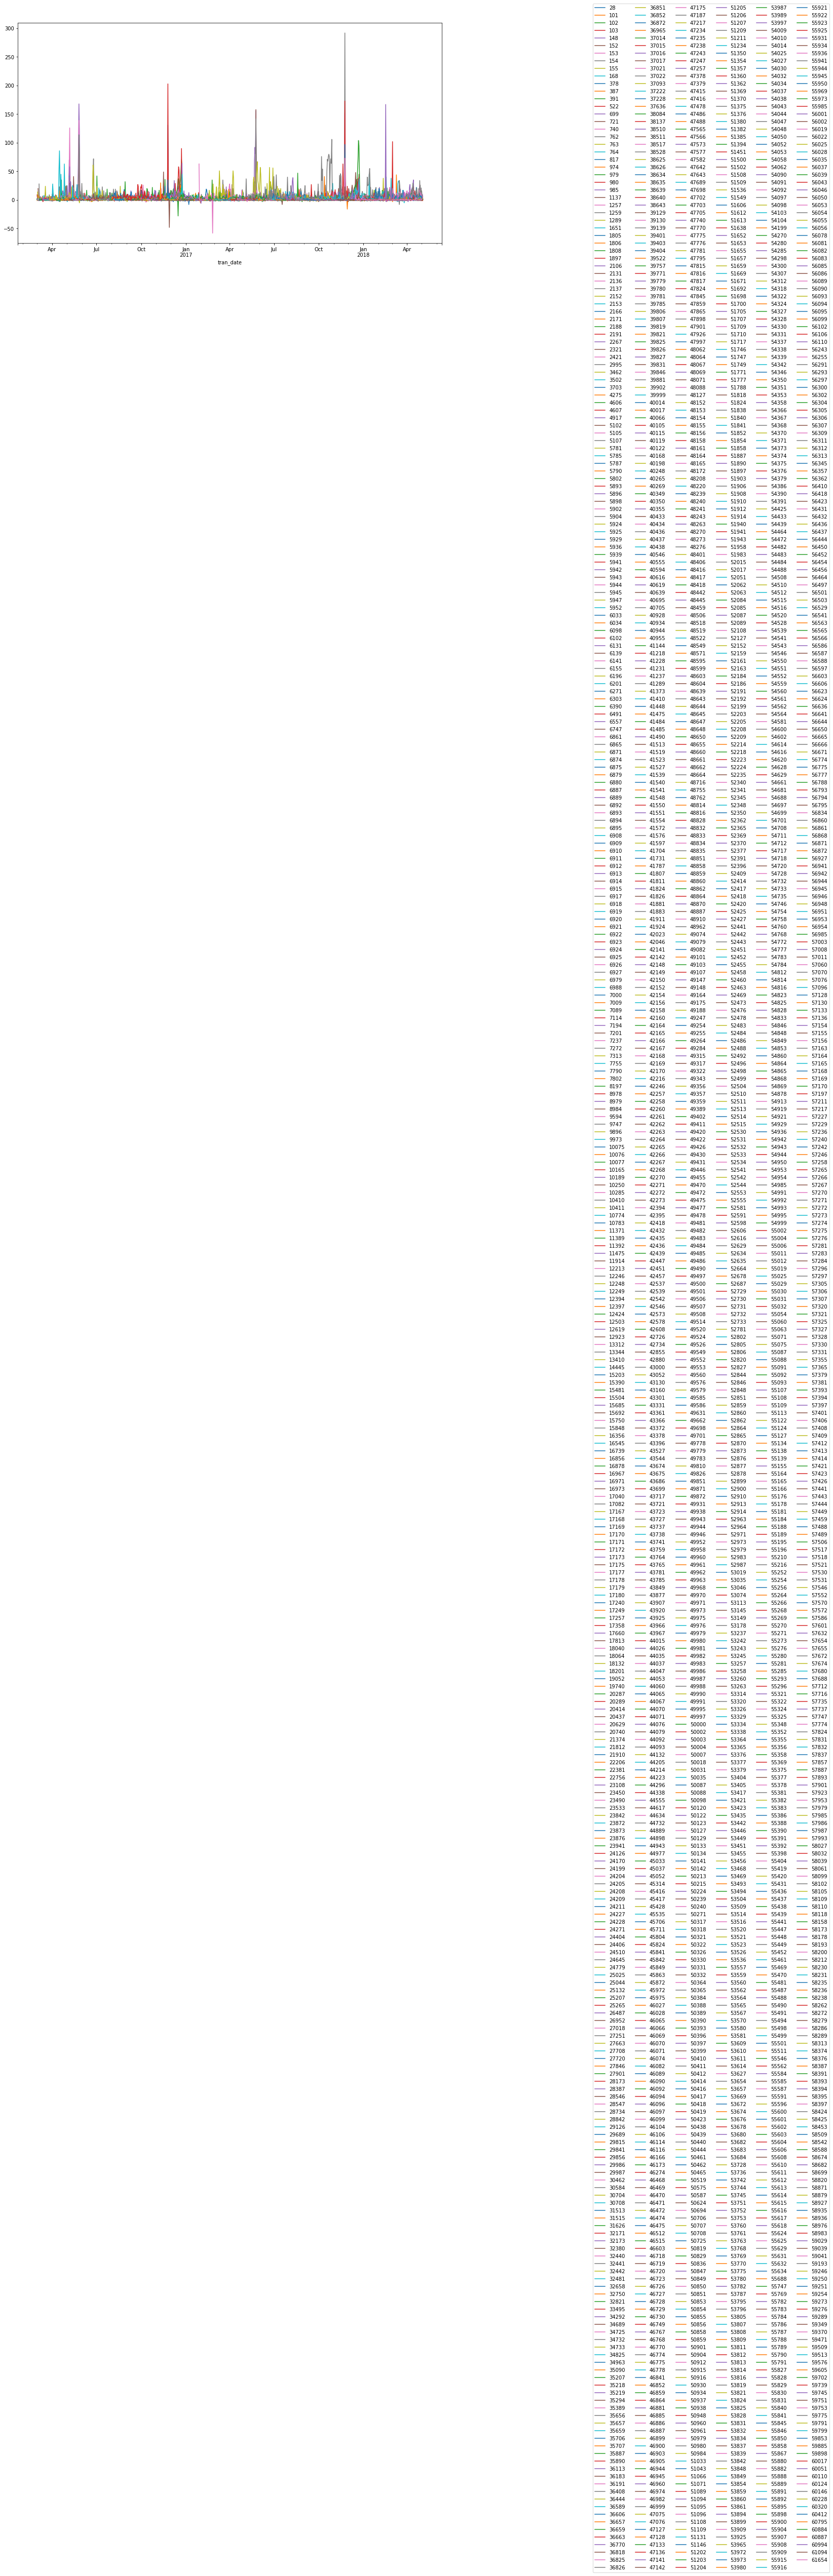

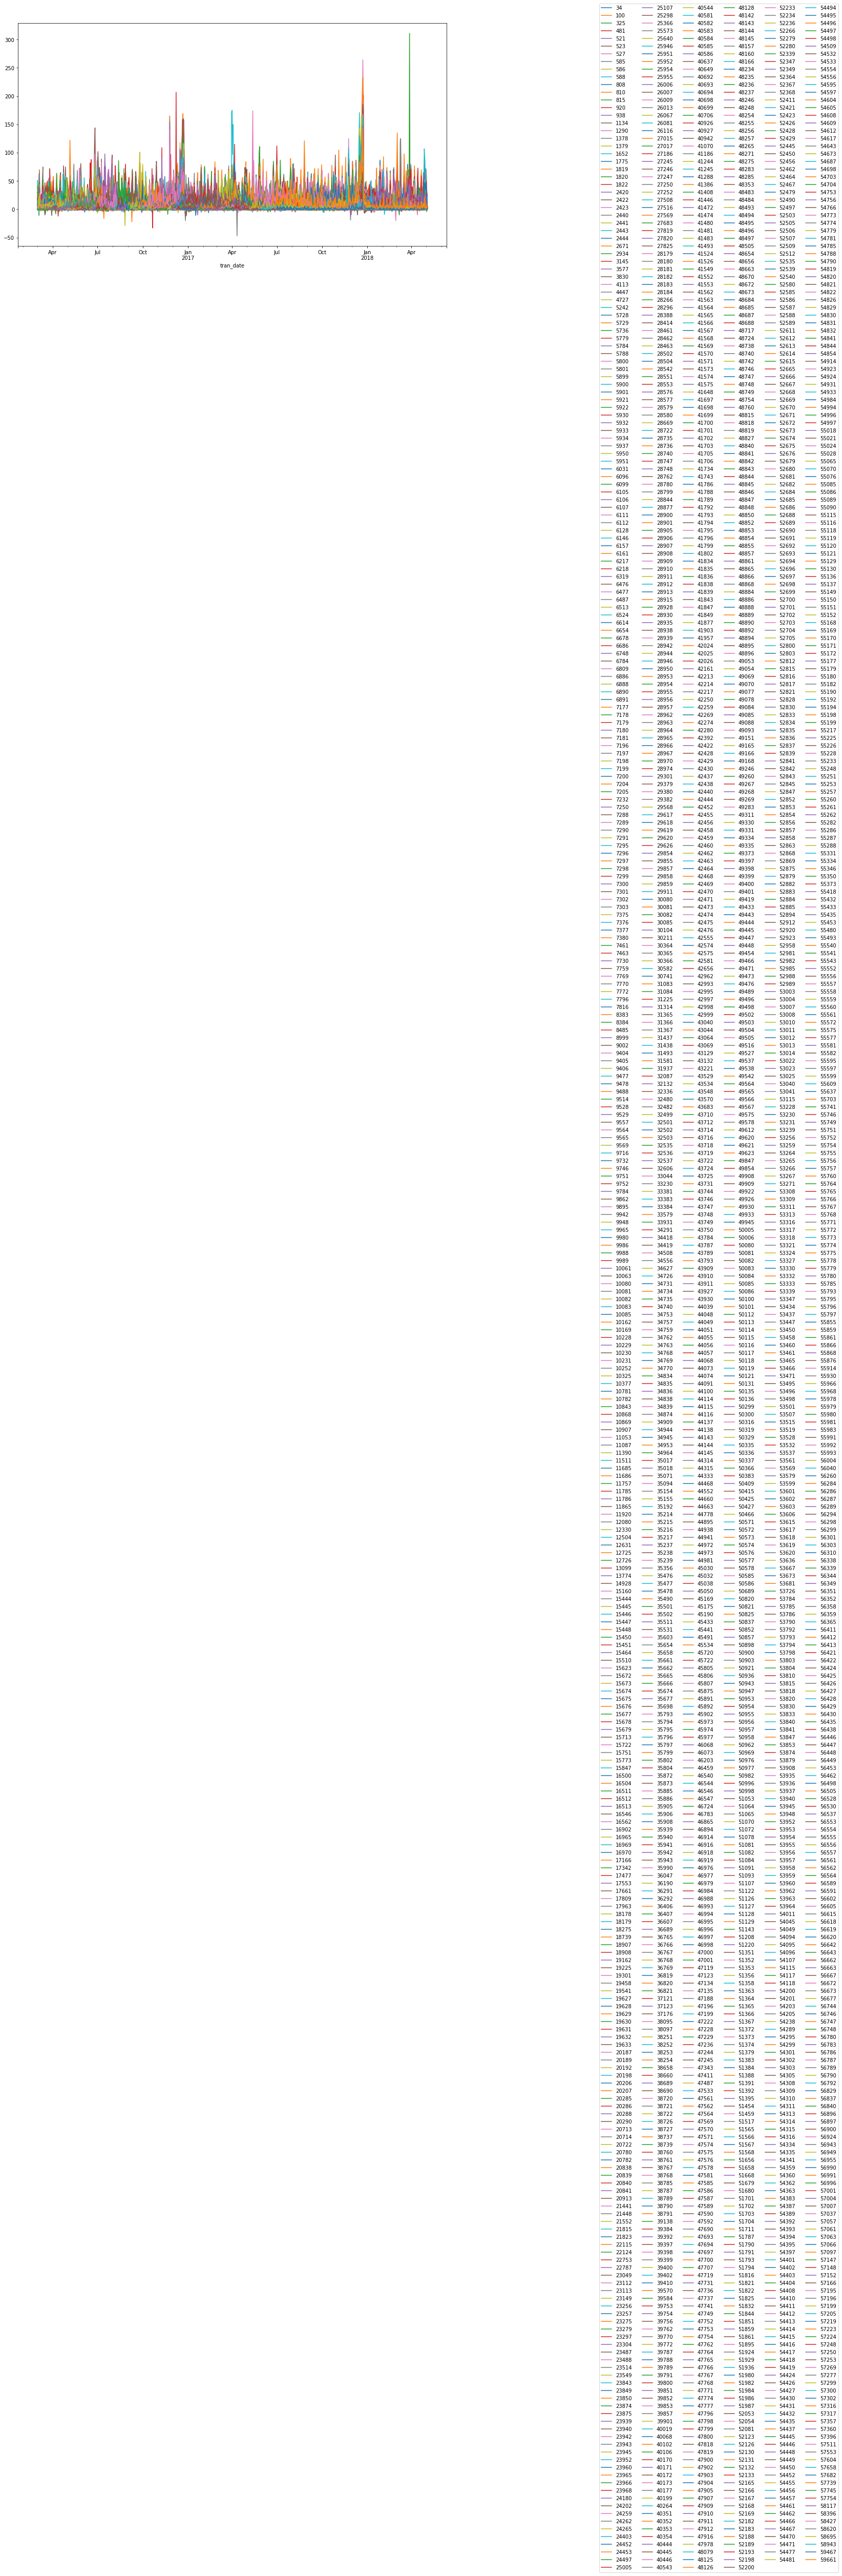

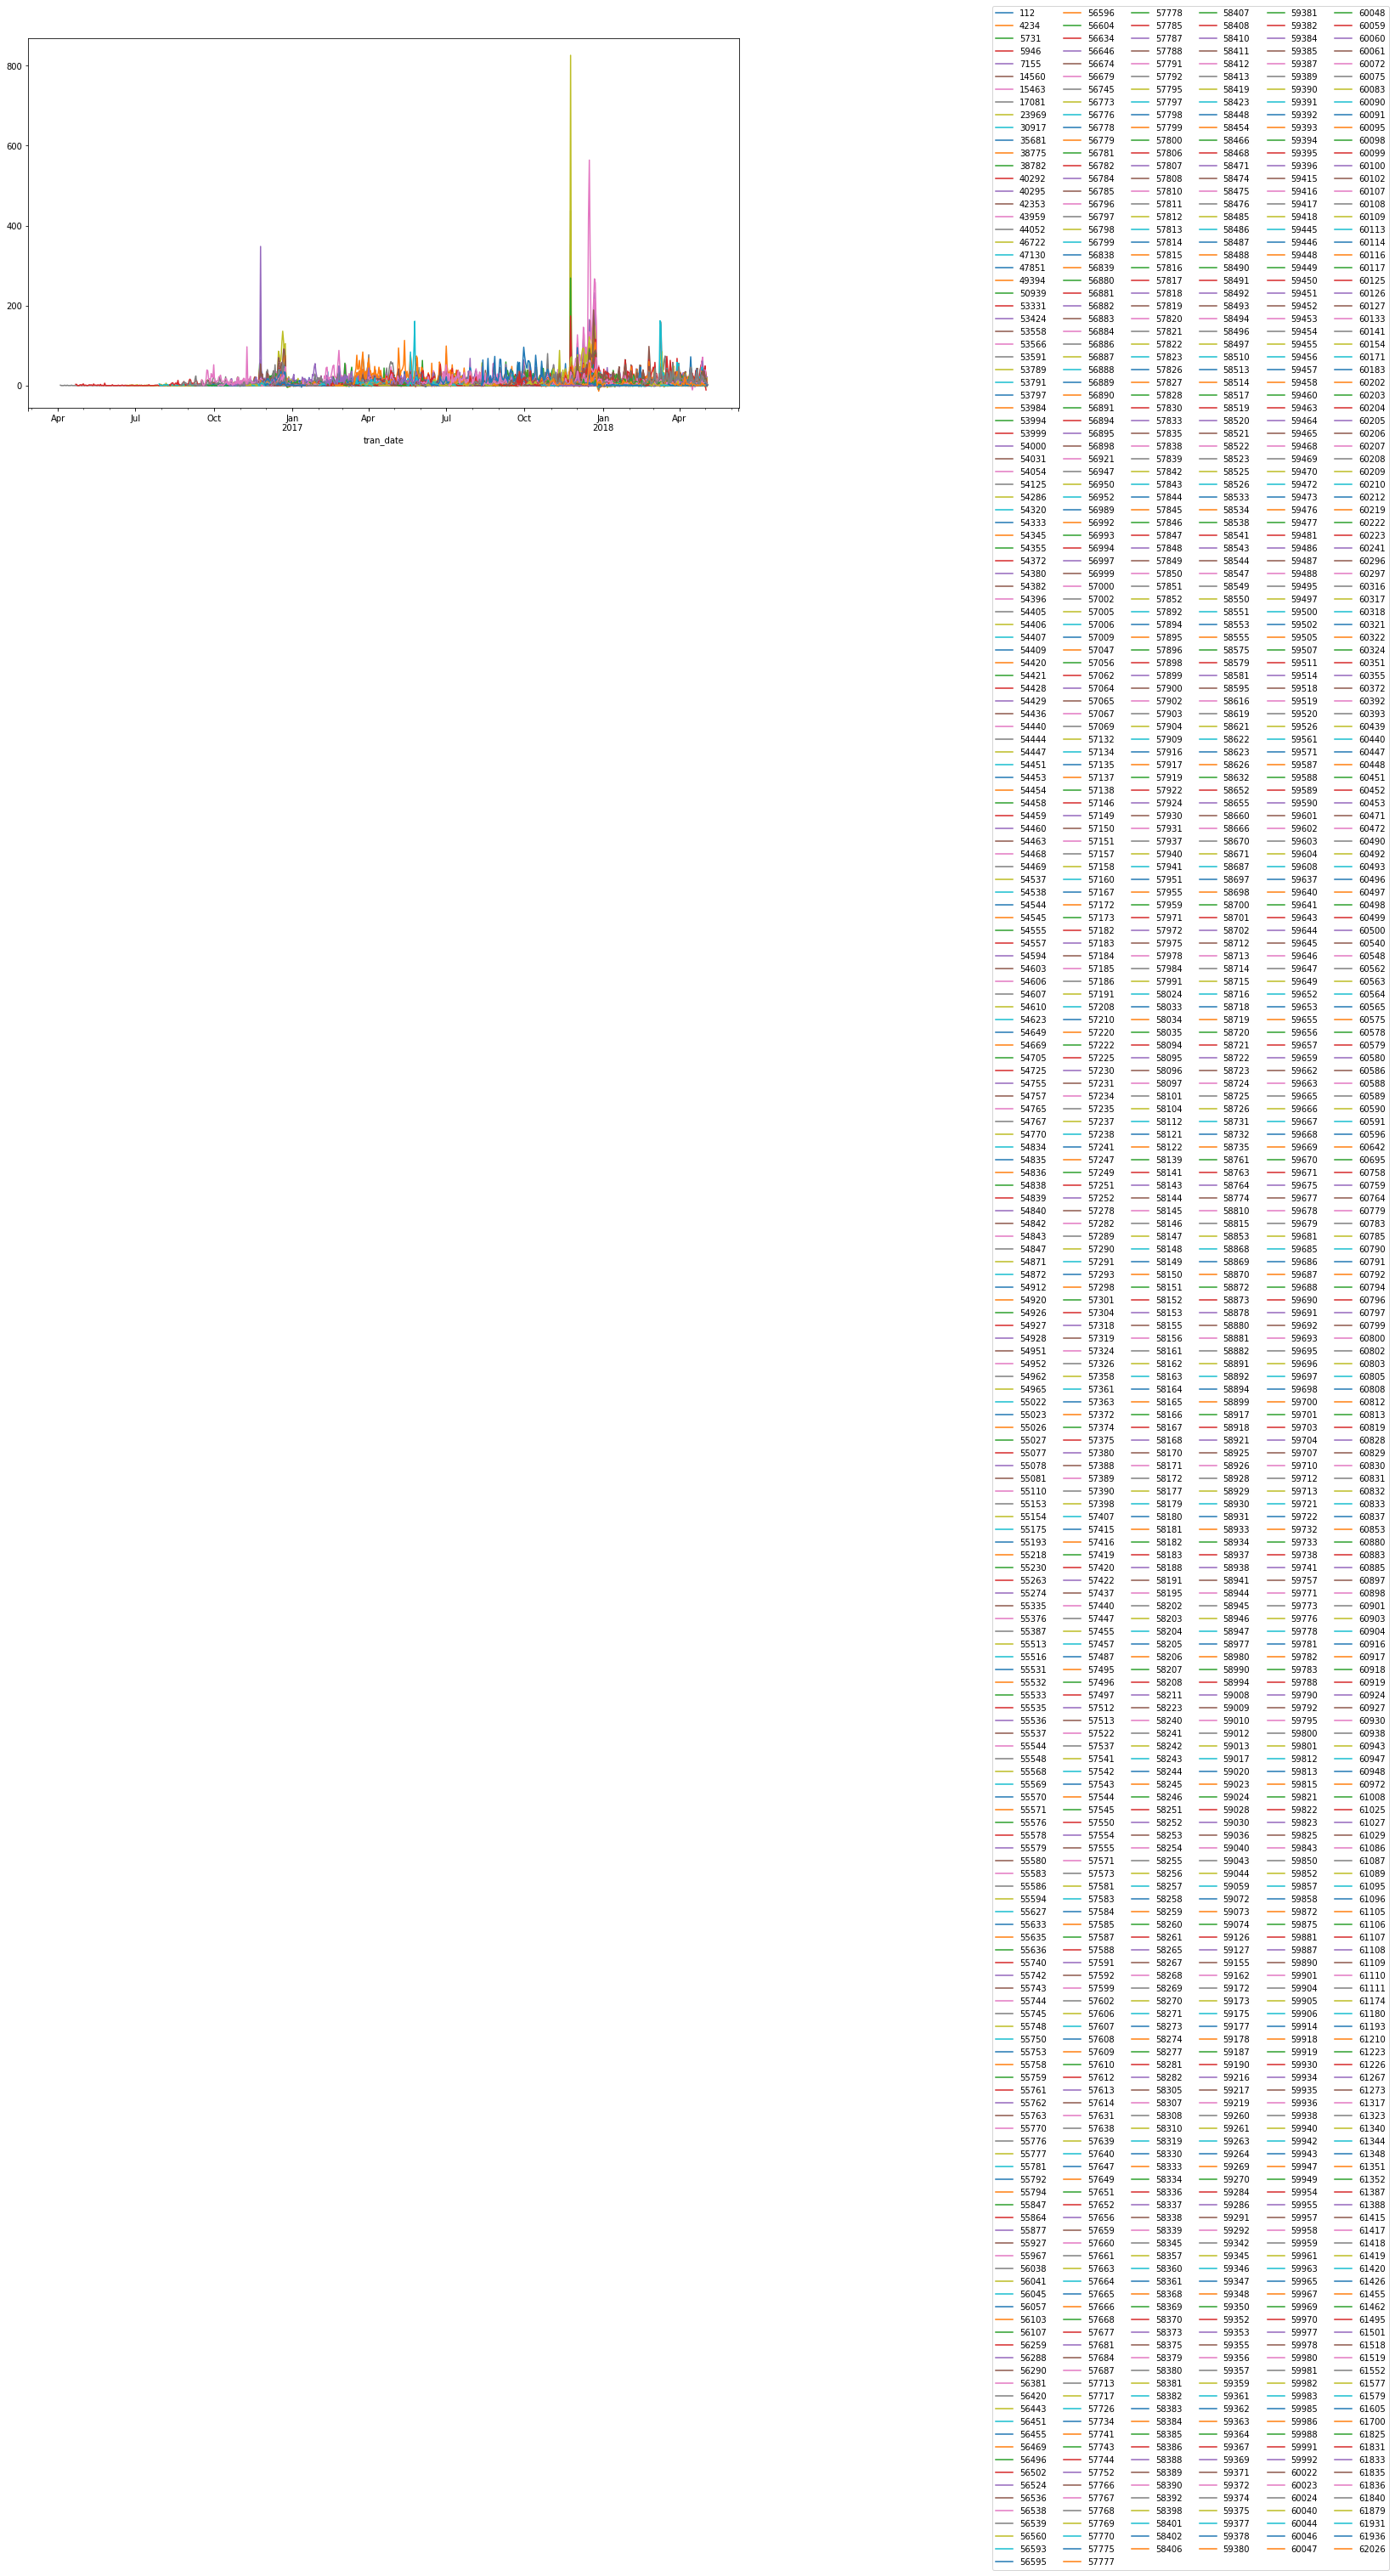

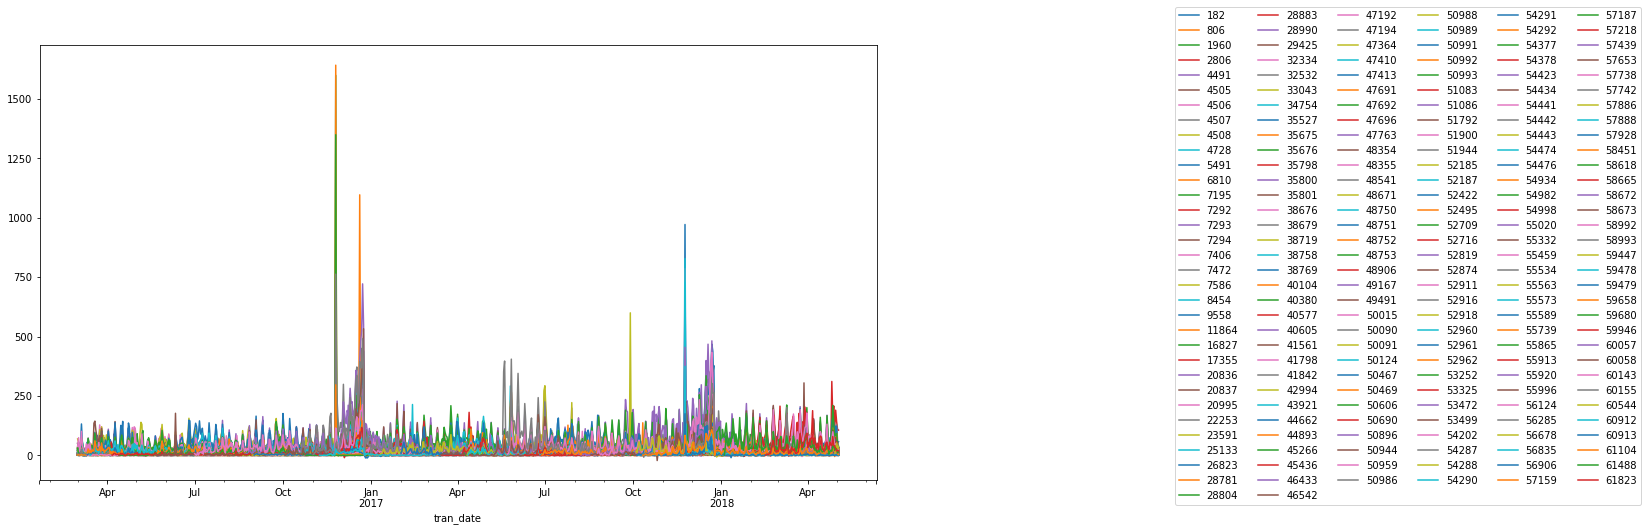

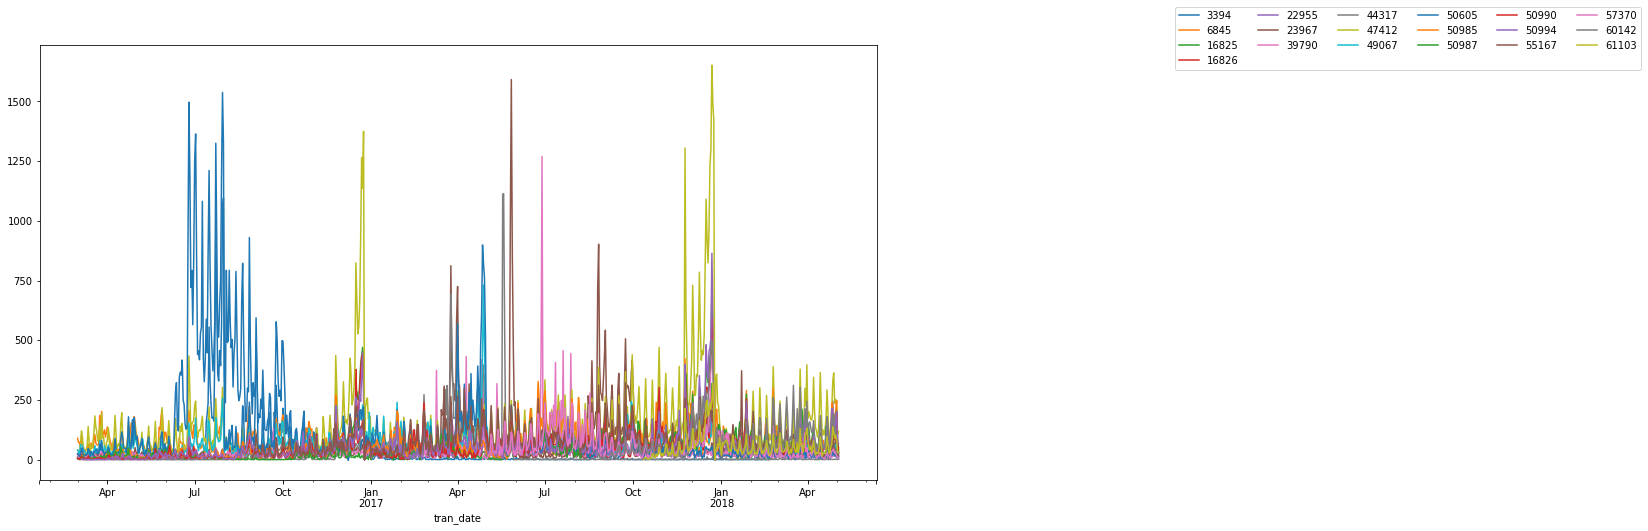

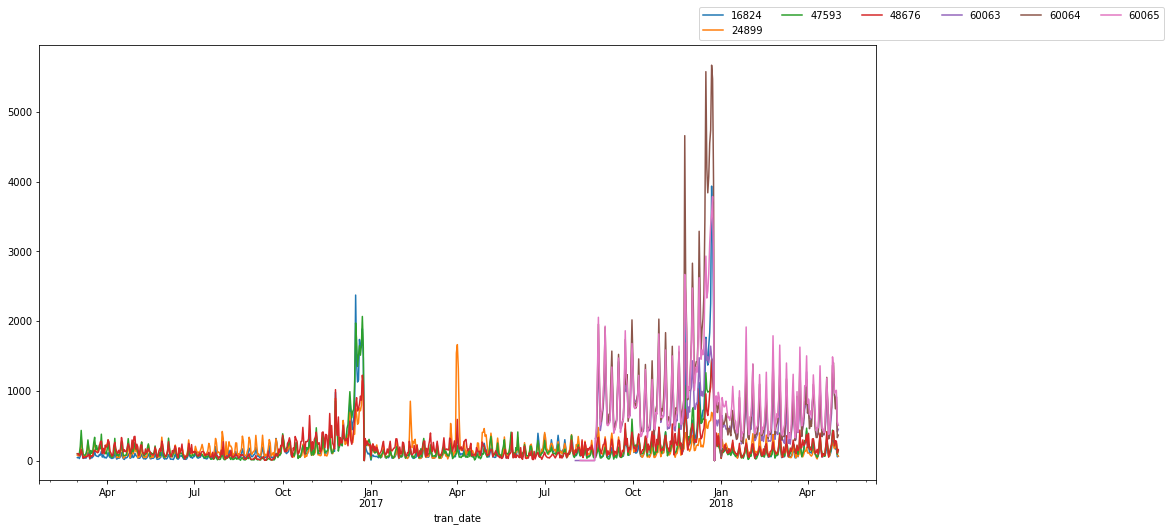

In [62]:
analyze_som.plot_all_timeseries(df_dict)

Have a look at the mean time series for each of the clusters

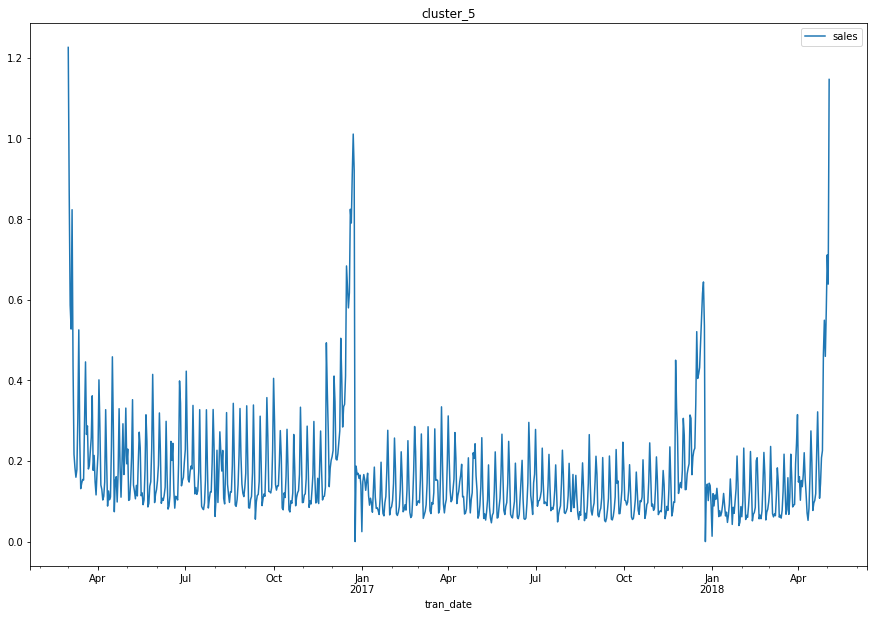

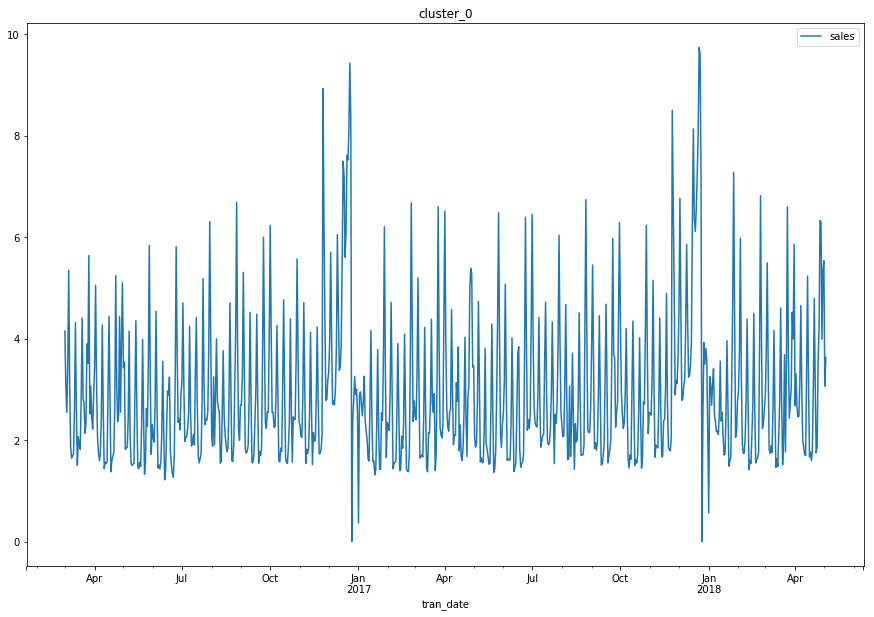

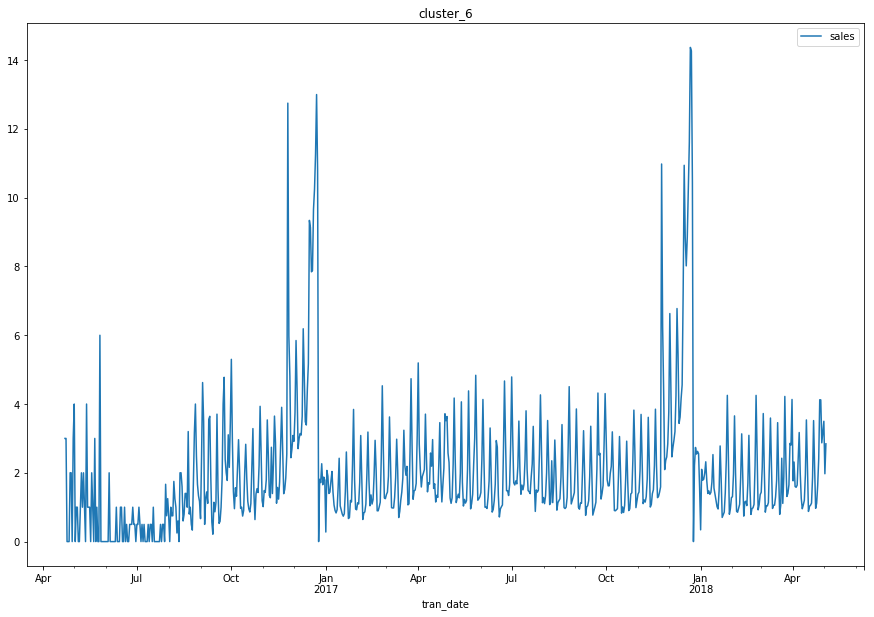

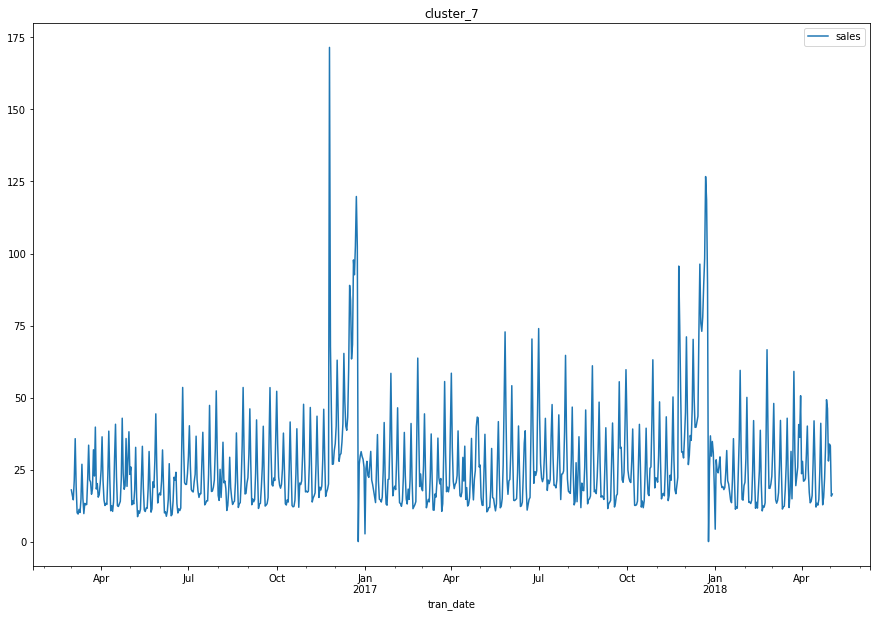

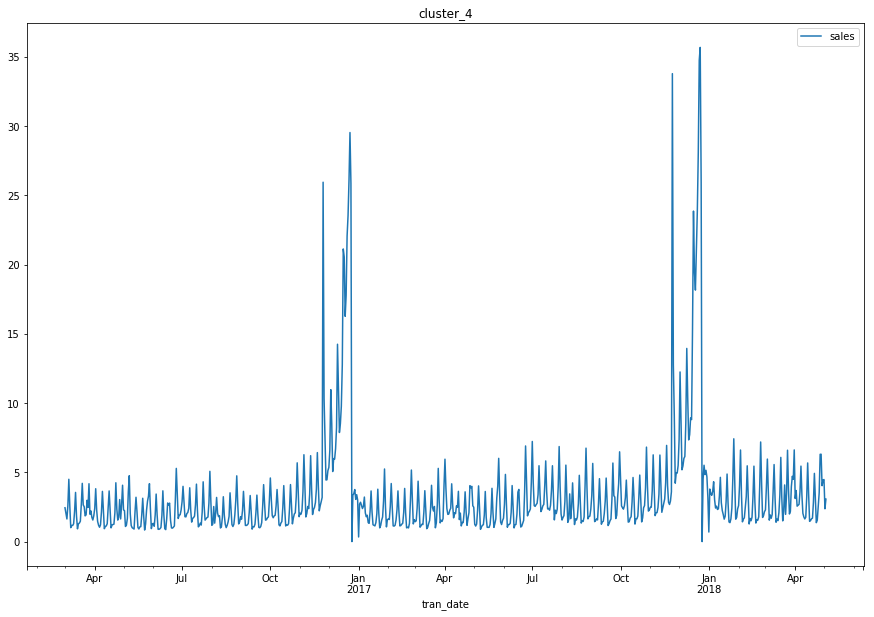

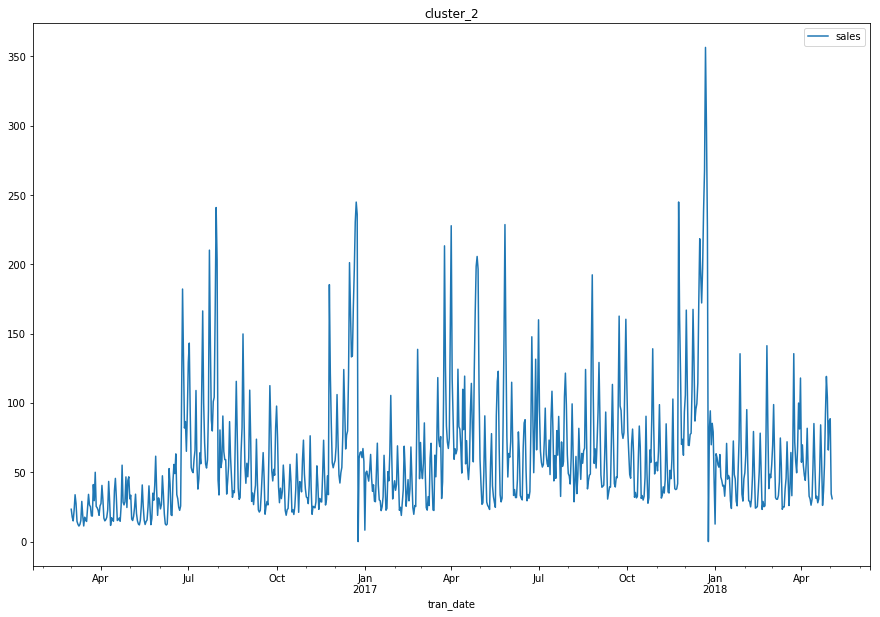

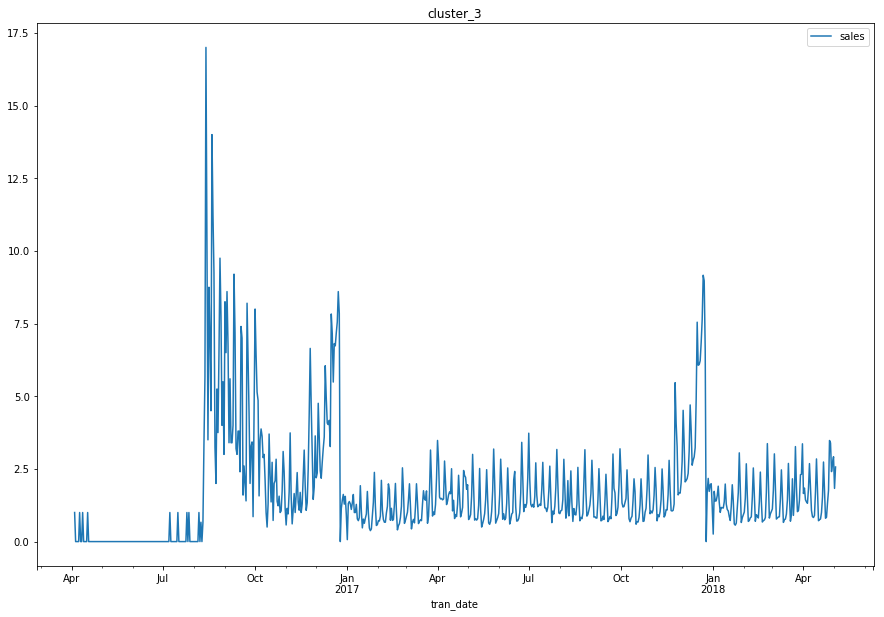

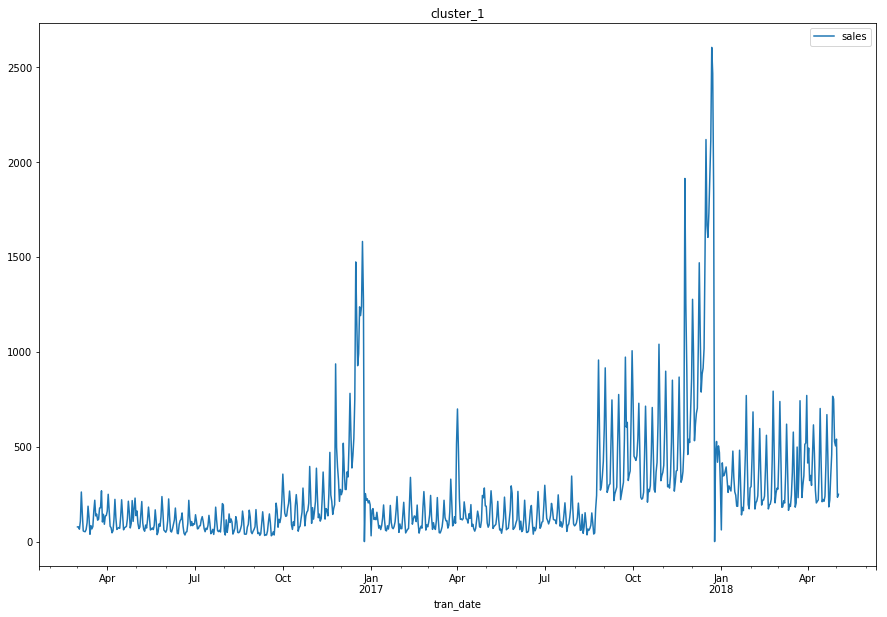

In [14]:
analyze_som.plot_mean_timeseries(df_dict)

Have a look at the median time series for each of the clusters

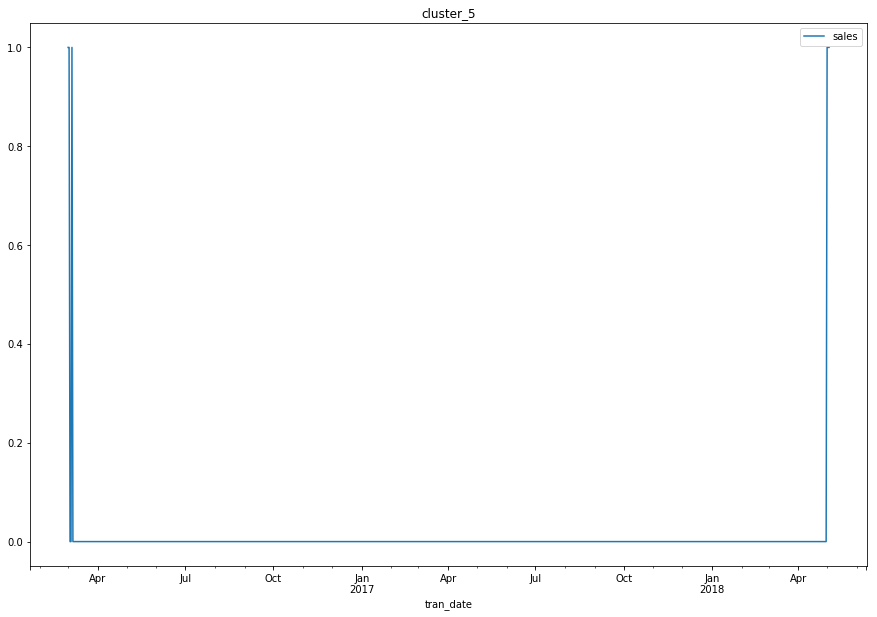

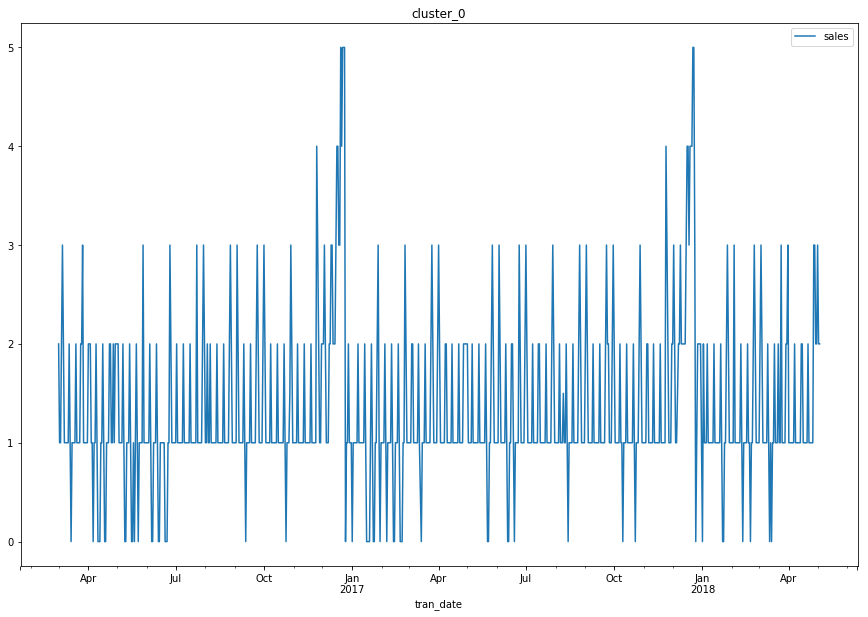

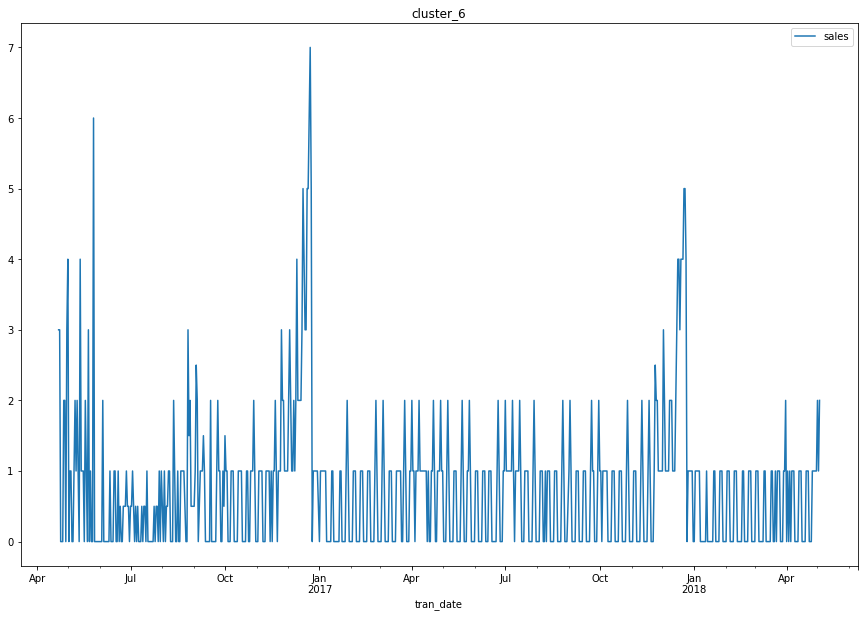

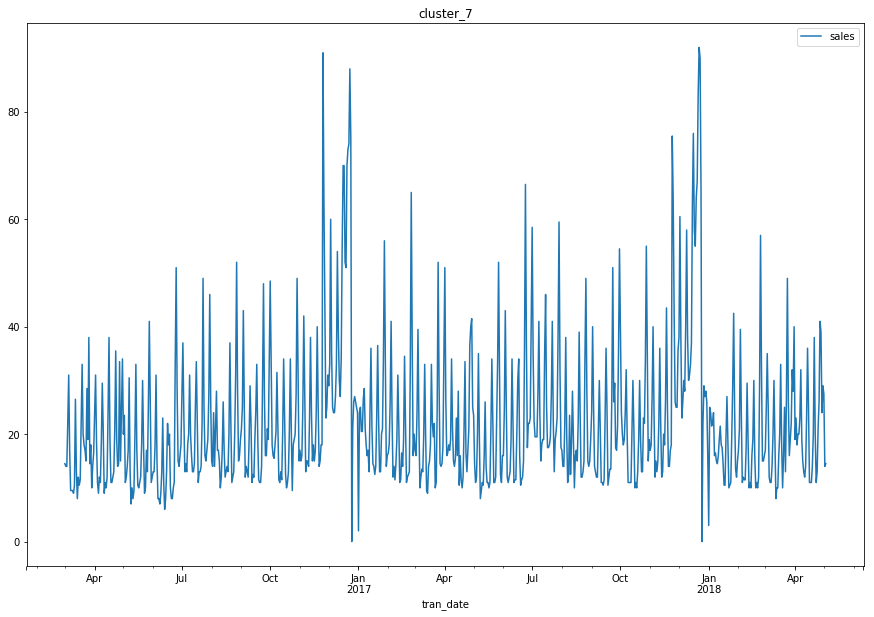

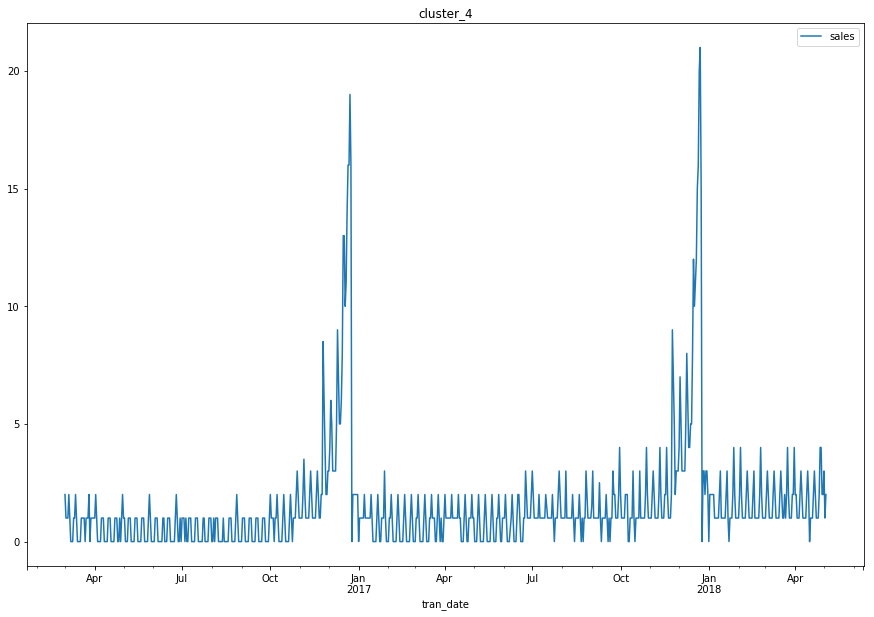

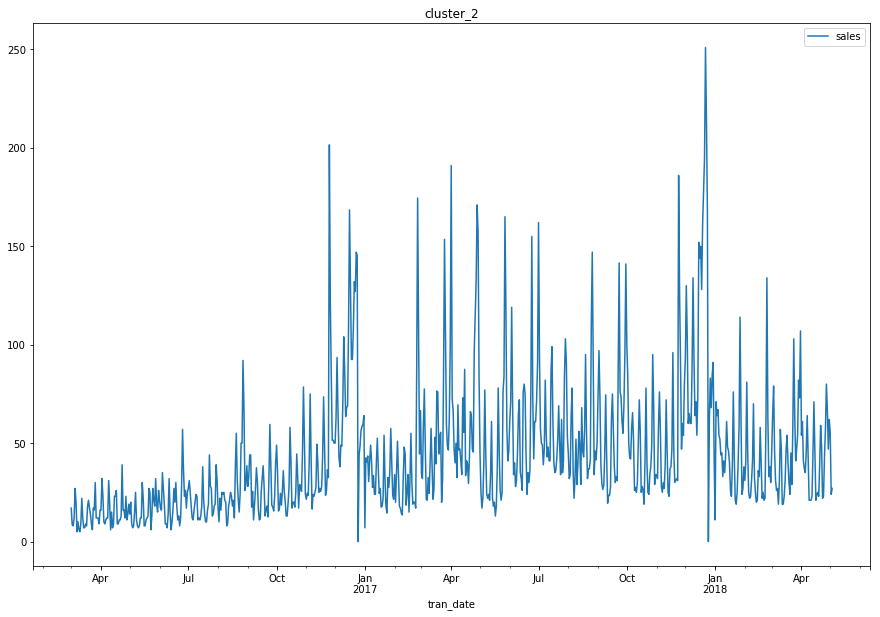

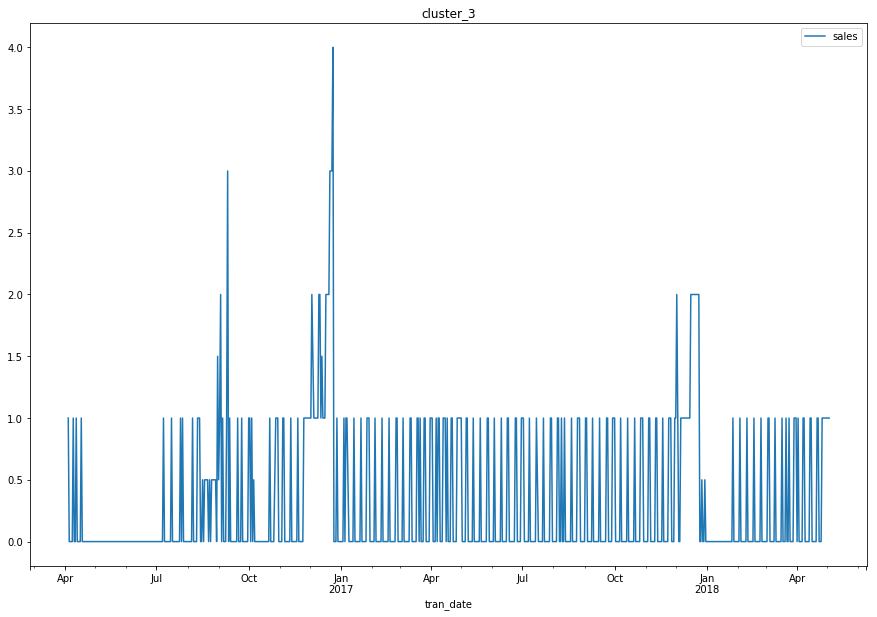

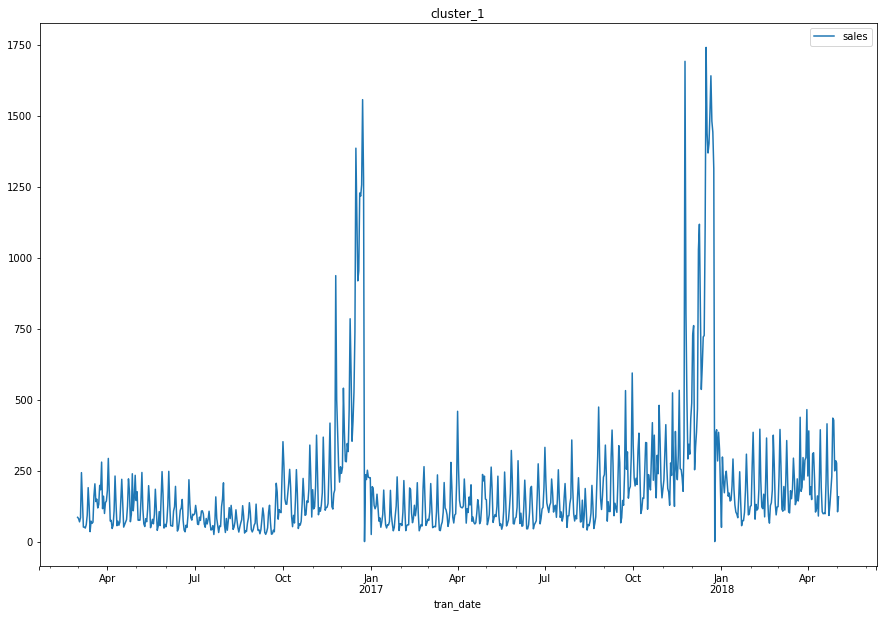

In [107]:
analyze_som.plot_median_timeseries(df_dict)

Have a look at the smoothed mean for each of the clusters

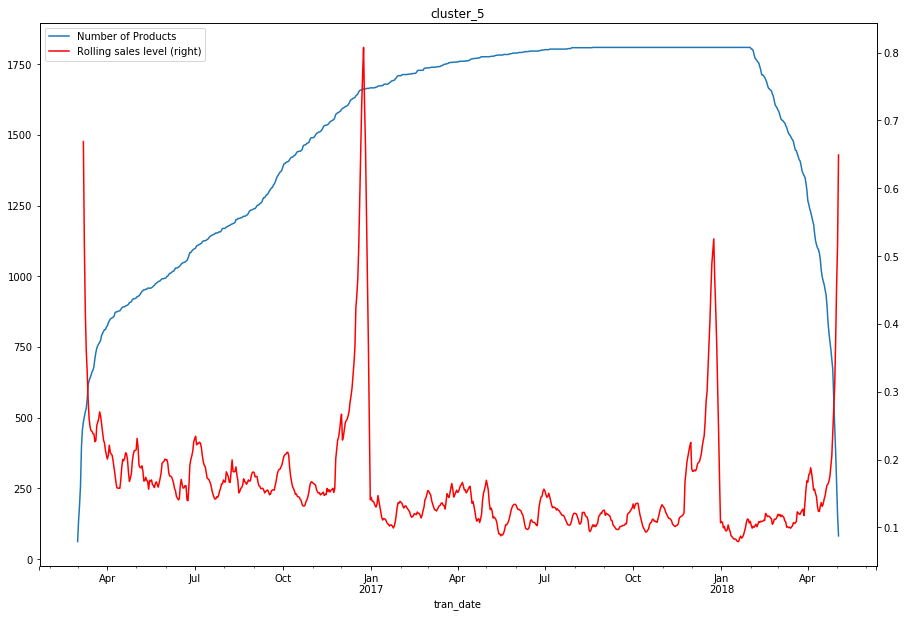

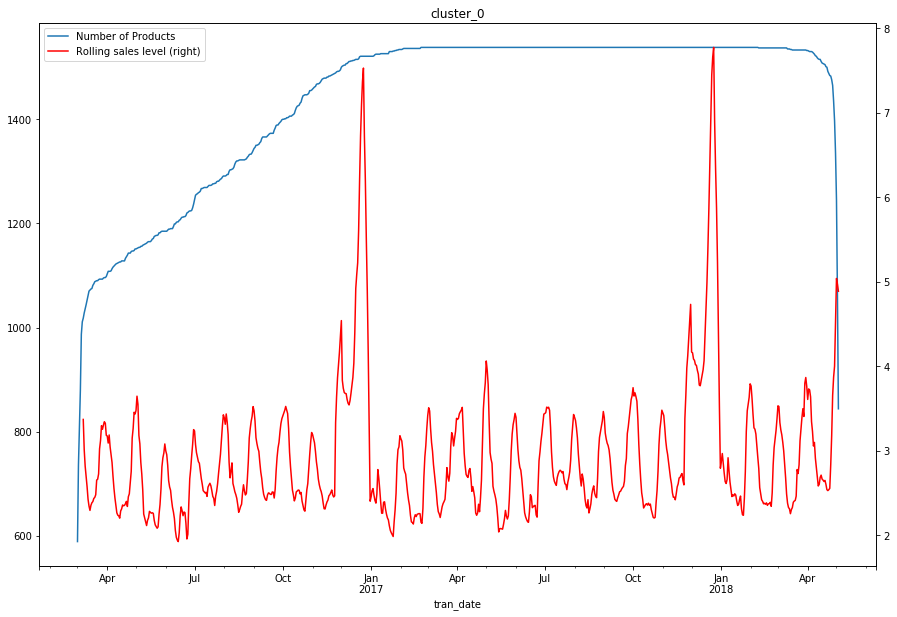

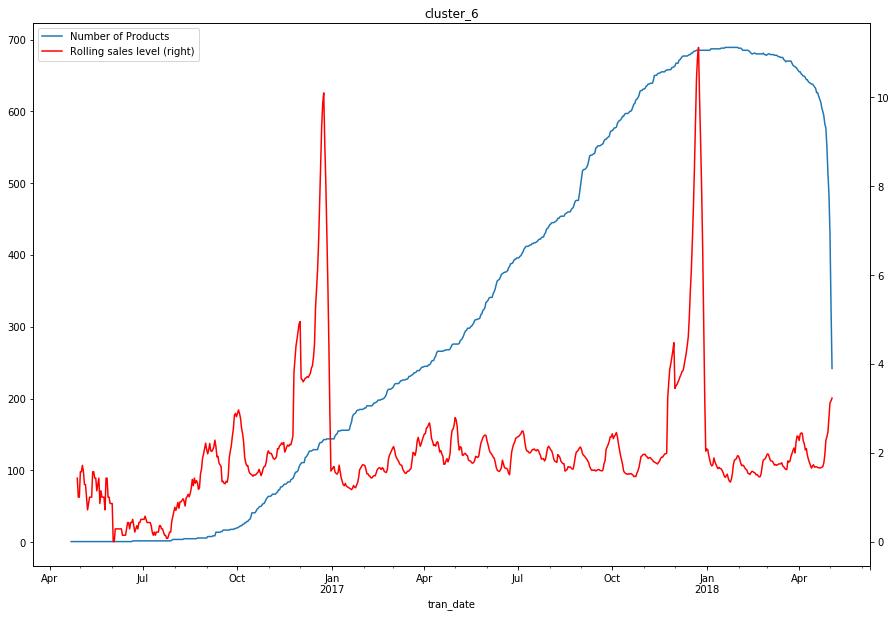

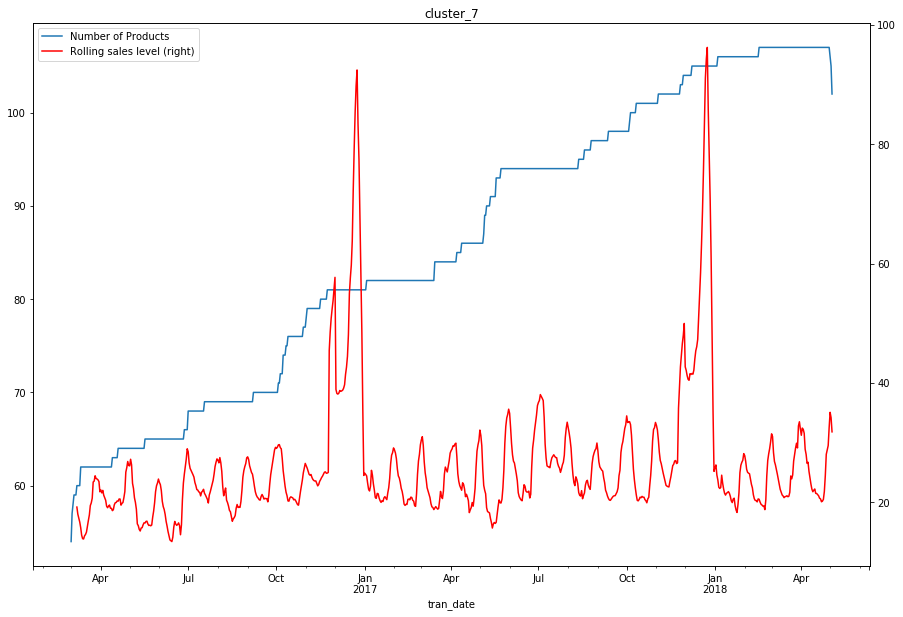

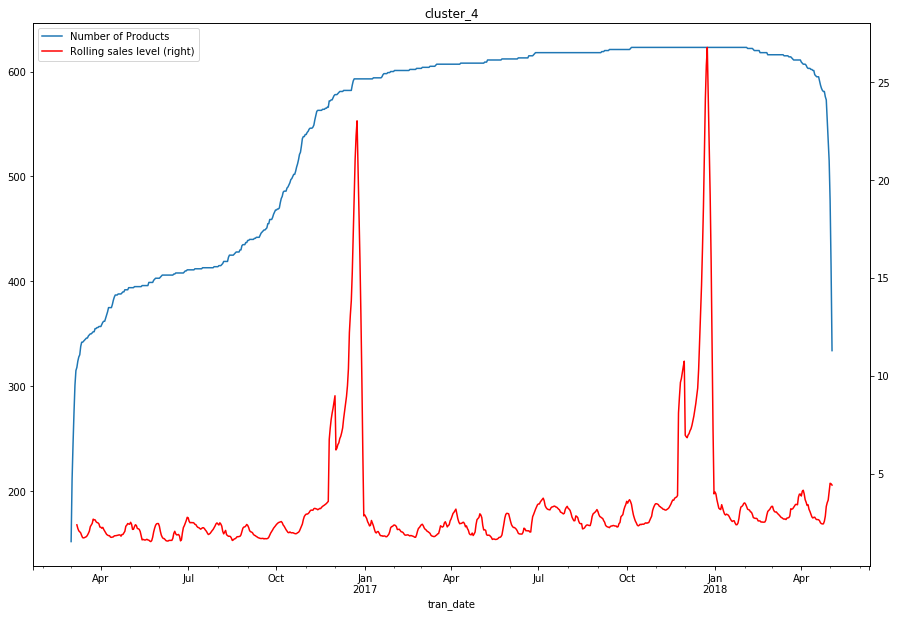

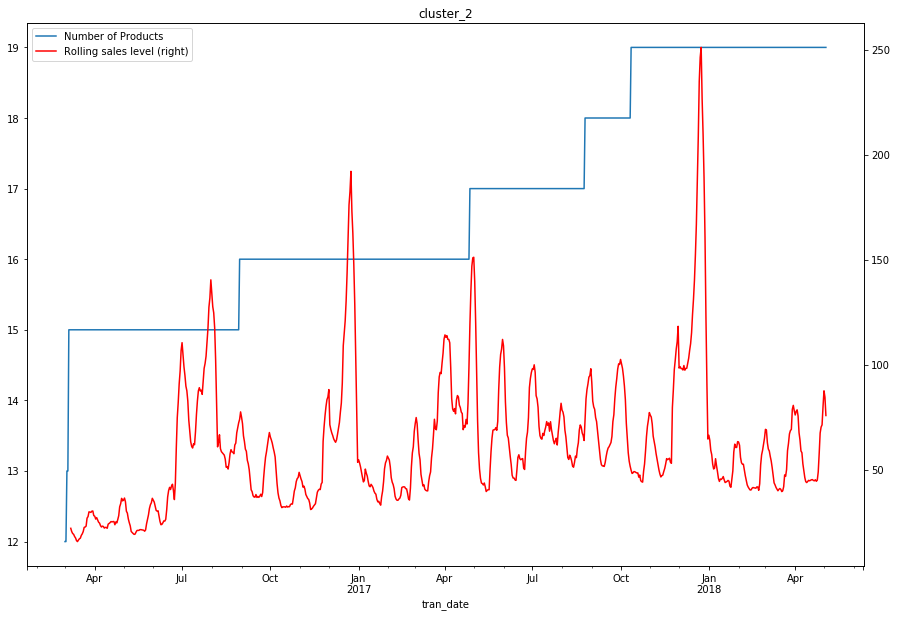

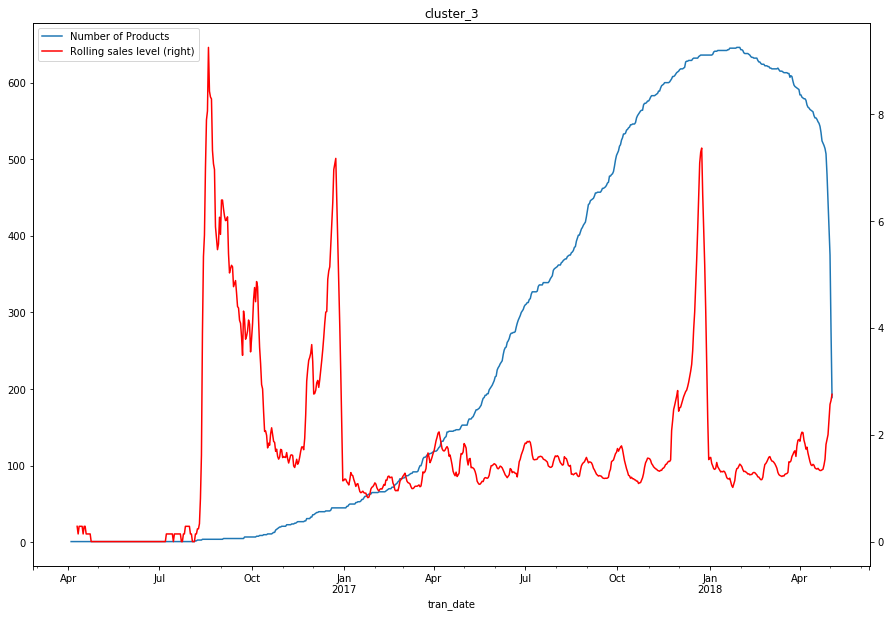

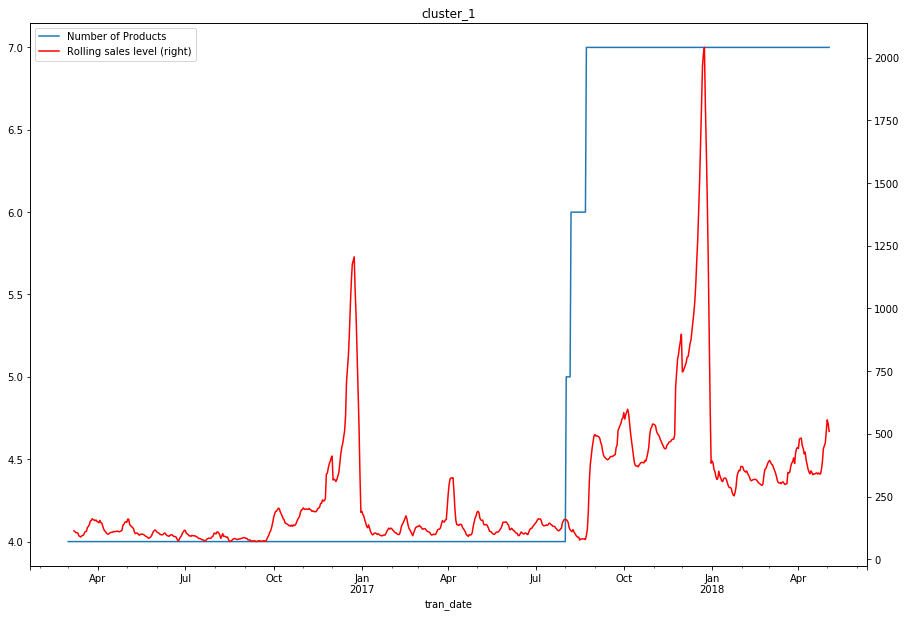

In [28]:
analyze_som.plot_rolling_mean_timeseries(df_dict, 'sales', plot_second=True,  period=7)

In [22]:
df_dict['cluster_0'].groupby('tran_date').count()

sku_key  cluster  sales  selling_price  avg_discount  stock_open  \
tran_date                                                                      
2016-03-01      589      589    589            589           589         589   
2016-03-02      736      736    736            736           736         736   
2016-03-03      805      805    805            805           805         805   
2016-03-04      880      880    880            880           880         880   
2016-03-05      987      987    987            987           987         987   
2016-03-06     1011     1011   1011           1011          1011        1011   
2016-03-07     1018     1018   1018           1018          1018        1018   
2016-03-08     1028     1028   1028           1028          1028        1028   
2016-03-09     1036     1036   1036           1036          1036        1036   
2016-03-10     1044     1044   1044           1044          1044        1044   
2016-03-11     1053     1053   1053           1053          1053        1053   
2016-03-12     1062     1062   1062           1062          1062        1062   
2016-03-13     1070     1070   1070           1070          1070        1070   
2016-03-14     1072     1072   1072           1072          1072        1072   
2016-03-15     1074     1074   1074           1074          1074        1074   
2016-03-16     1075     1075   1075           1075          1075        1075   
2016-03-17     1081     1081   1081           1081          1081        1081   
2016-03-18     1084     1084   1084           1084          1084        1084   
2016-03-19     1088     1088   1088           1088          1088        1088   
2016-03-20     1089     1089   1089           1089          1089        1089   
2016-03-21     1090     1090   1090           1090          1090        1090   
2016-03-22     1090     1090   1090           1090          1090        1090   
2016-03-23     1092     1092   1092           1092          1092        1092   
2016-03-24     1093     1093   1093           1093          1093        1093   
2016-03-25     1093     1093   1093           1093          1093        1093   
2016-03-26     1093     1093   1093           1093          1093        1093   
2016-03-27     1093     1093   1093           1093          1093        1093   
2016-03-28     1095     1095   1095           1095          1095        1095   
2016-03-29     1096     1096   1096           1096          1096        1096   
2016-03-30     1096     1096   1096           1096          1096        1096   
...             ...      ...    ...            ...           ...         ...   
2018-04-04     1530     1530   1530           1530          1530        1530   
2018-04-05     1530     1530   1530           1530          1530        1530   
2018-04-06     1529     1529   1529           1529          1529        1529   
2018-04-07     1527     1527   1527           1527          1527        1527   
2018-04-08     1525     1525   1525           1525          1525        1525   
2018-04-09     1522     1522   1522           1522          1522        1522   
2018-04-10     1521     1521   1521           1521          1521        1521   
2018-04-11     1518     1518   1518           1518          1518        1518   
2018-04-12     1516     1516   1516           1516          1516        1516   
2018-04-13     1515     1515   1515           1515          1515        1515   
2018-04-14     1515     1515   1515           1515          1515        1515   
2018-04-15     1511     1511   1511           1511          1511        1511   
2018-04-16     1508     1508   1508           1508          1508        1508   
2018-04-17     1507     1507   1507           1507          1507        1507   
2018-04-18     1506     1506   1506           1506          1506        1506   
2018-04-19     1505     1505   1505           1505          1505        1505   
2018-04-20     1501     1501   1501           1501          1501        1501   
2018-04-21  

Have a look at the amount of time series which start within the specified period or which started priod to the start of the period

cluster_5, there are 1809 skus and 186437 sales.


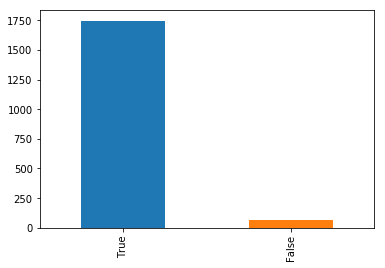

cluster_0, there are 1538 skus and 3370749 sales.


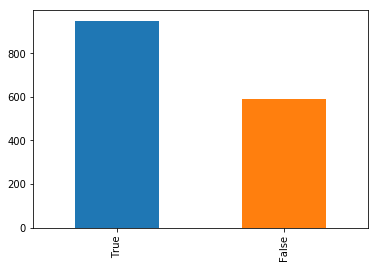

cluster_6, there are 695 skus and 551134 sales.


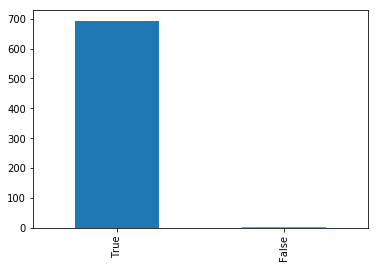

cluster_7, there are 107 skus and 1830244 sales.


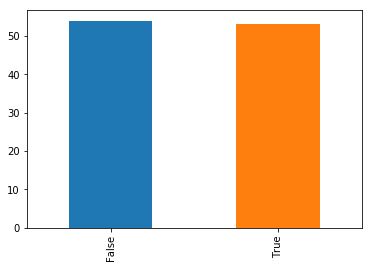

cluster_4, there are 623 skus and 1523064 sales.


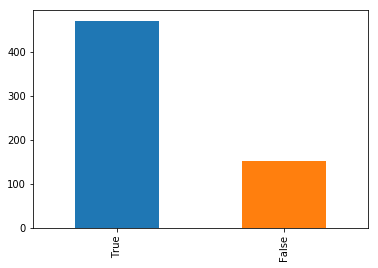

cluster_2, there are 19 skus and 833348 sales.


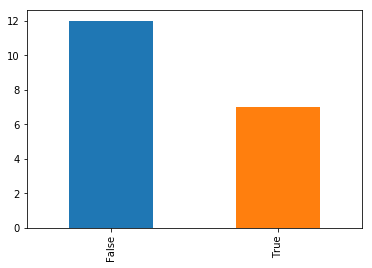

cluster_3, there are 653 skus and 333057 sales.


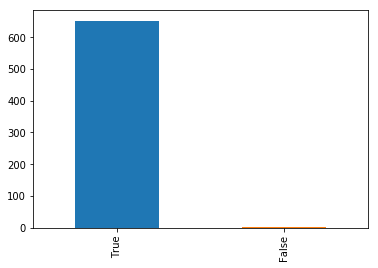

cluster_1, there are 7 skus and 1231108 sales.


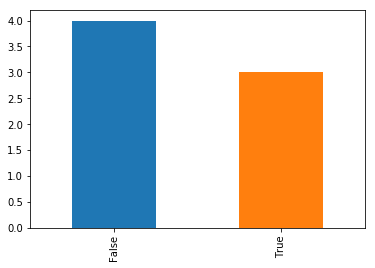

In [109]:
for i, j in df_dict.items():
    print('{}, there are {} skus and {} sales.'.format(i, len(j['sku_key'].unique()), sum(j['sales'])))
    pivot_t = pd.pivot_table(j, index='sku_key', columns='tran_date', values='sales')
    pivot_t['nan'] = pivot_t.iloc[:,0].apply(np.isnan)
    pivot_t['nan'].value_counts().plot(kind='bar')
    plt.show()

Have a look at the distribution of the continuous variables for each cluster

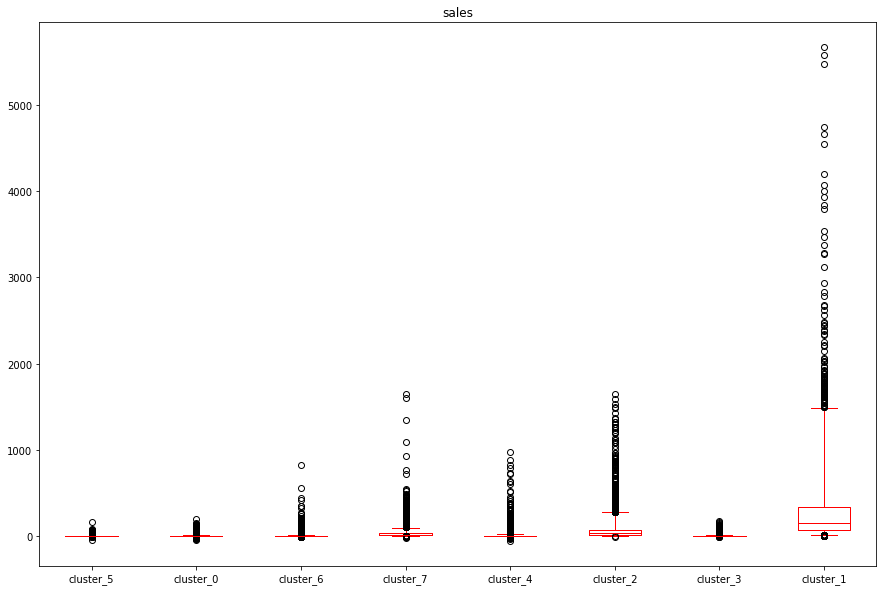

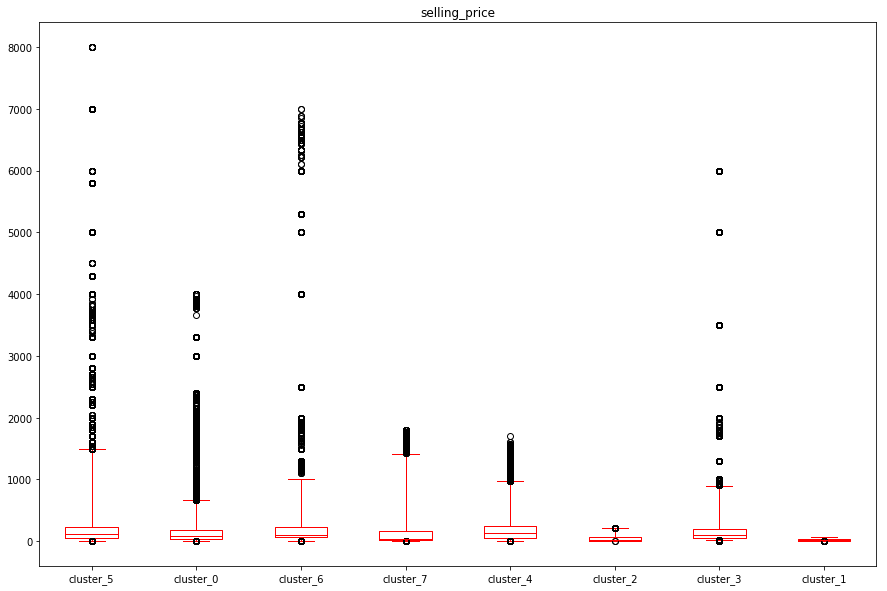

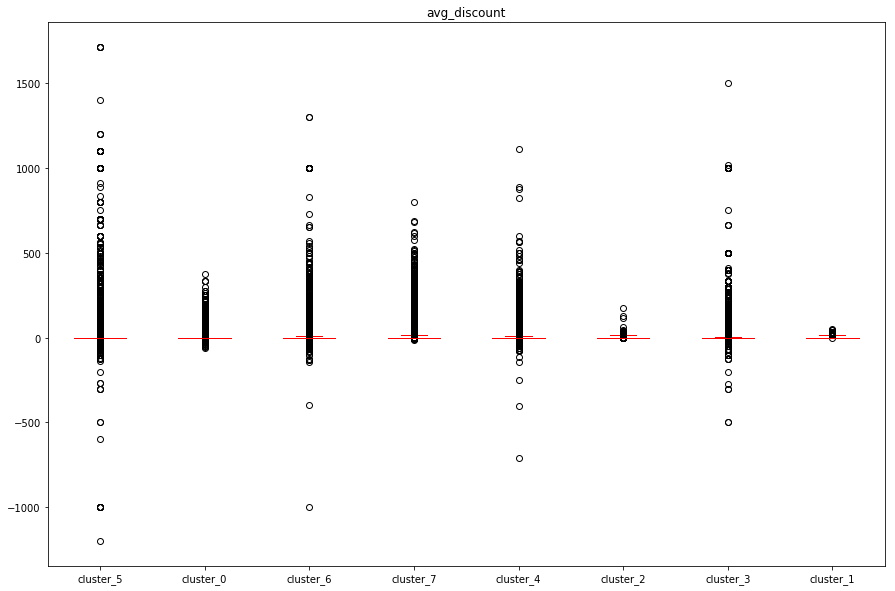

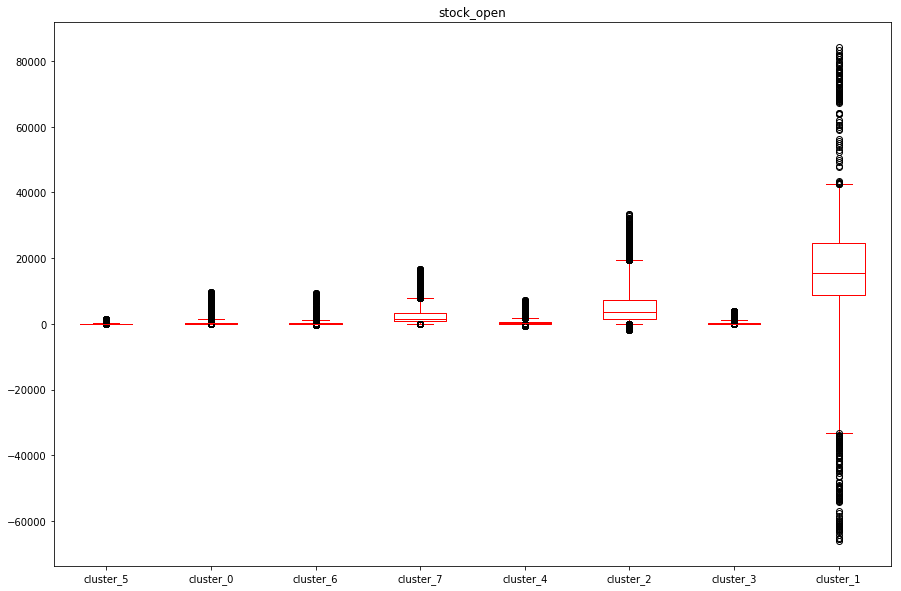

In [110]:
analyze_som.plot_cluster_continuous_box(df_dict, run_cont, True)
#OPTIONAL BELOW
#analyze_som.plot_cluster_continuous(df_dict, run_cont, colors, True)
#analyze_som.plot_cluster_continuous_violin(df_dict, run_cont, True)

Have a look at the number of returns per cluster and relative percentage

cluster_5 had 1187001 sale events
cluster_0 had 1142313 sale events
cluster_6 had 237727 sale events
cluster_7 had 68256 sale events
cluster_4 had 434405 sale events
cluster_2 had 13340 sale events
cluster_3 had 191318 sale events
cluster_1 had 3975 sale events


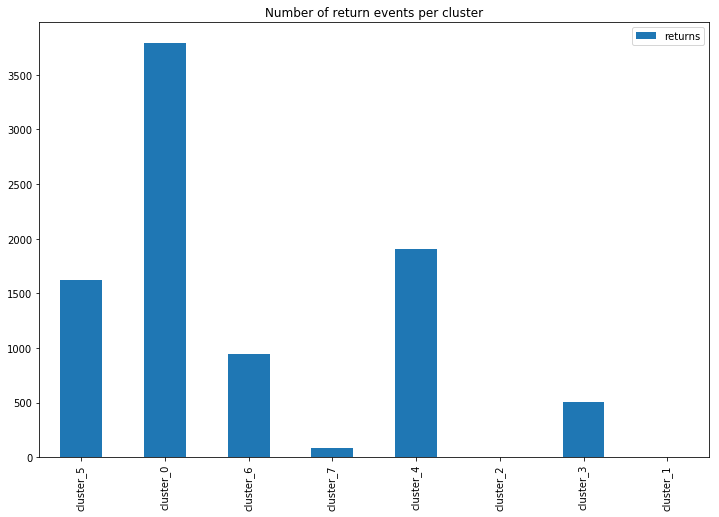

In [148]:
listy = {}
for a, i in df_dict.items():
    print('{} had {} sale events'.format(a, len(i['sales'])))
    x = i[i['sales'] < 0]['sales'].count()
    listy[a] = x
f, ax = plt.subplots(figsize=(12,8))
pd.DataFrame(listy, index=['returns']).T.plot(kind='bar', ax=ax)
plt.title('Number of return events per cluster')
plt.show()

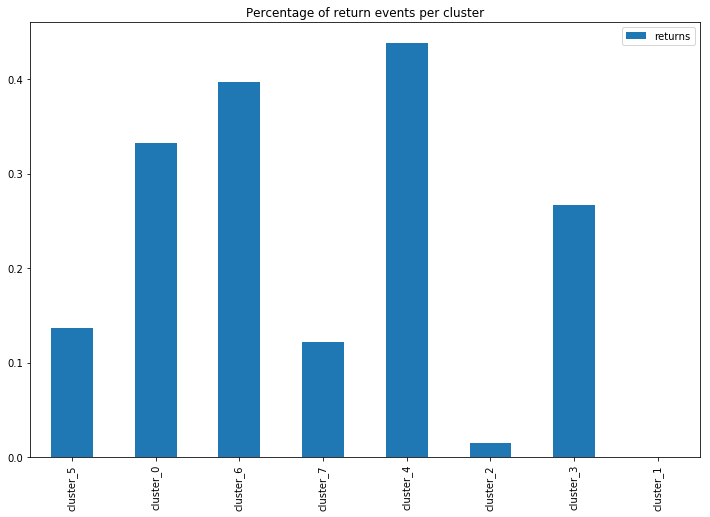

In [151]:
listy = {}
for a, i in df_dict.items():
    x = i[i['sales'] < 0]['sales'].count()/i['sales'].count()*100
    listy[a] = x
    
f, ax = plt.subplots(figsize=(12,8))
pd.DataFrame(listy, index=['returns']).T.plot(kind='bar', ax=ax)
plt.title('Percentage of return events per cluster')
plt.show()

Look at the stock shortages

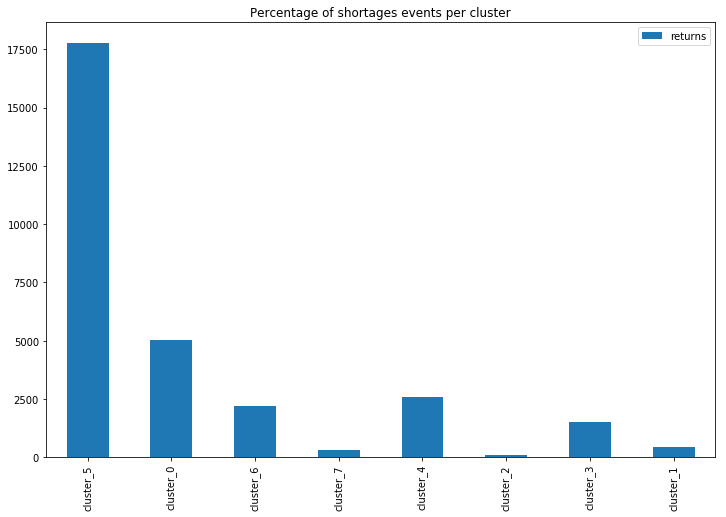

In [159]:
listy = {}
for a, i in df_dict.items():
    x = i[i['stock_open'] < 0]['stock_open'].count()
    listy[a] = x
    
f, ax = plt.subplots(figsize=(12,8))
pd.DataFrame(listy, index=['returns']).T.plot(kind='bar', ax=ax)
plt.title('Percentage of shortages events per cluster')
plt.show()

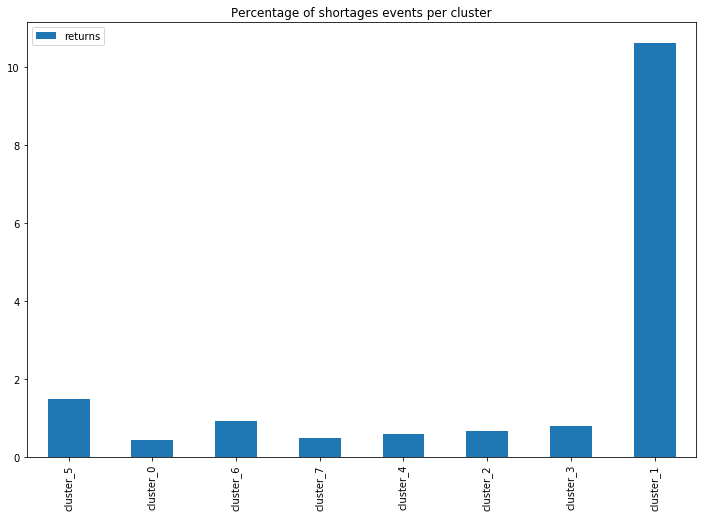

In [160]:
listy = {}
for a, i in df_dict.items():
    x = i[i['stock_open'] < 0]['stock_open'].count()/i['stock_open'].count()*100
    listy[a] = x
    
f, ax = plt.subplots(figsize=(12,8))
pd.DataFrame(listy, index=['returns']).T.plot(kind='bar', ax=ax)
plt.title('Percentage of shortages events per cluster')
plt.show()

Categorical variables per cluster



 sku_department


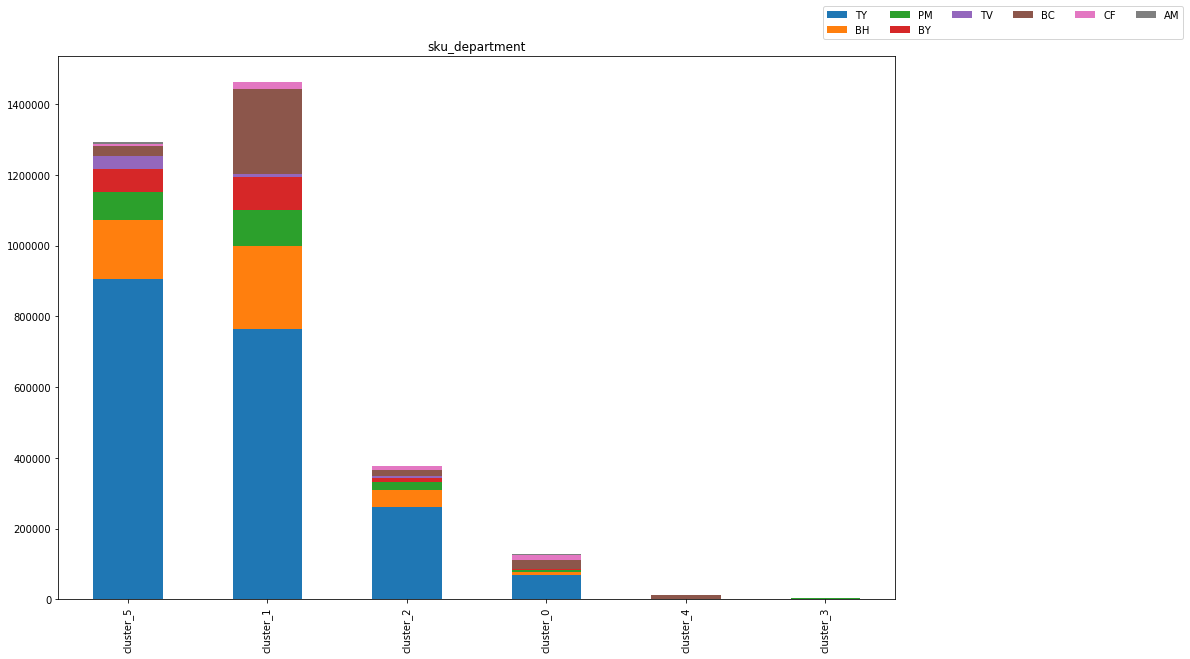



 sku_subdepartment


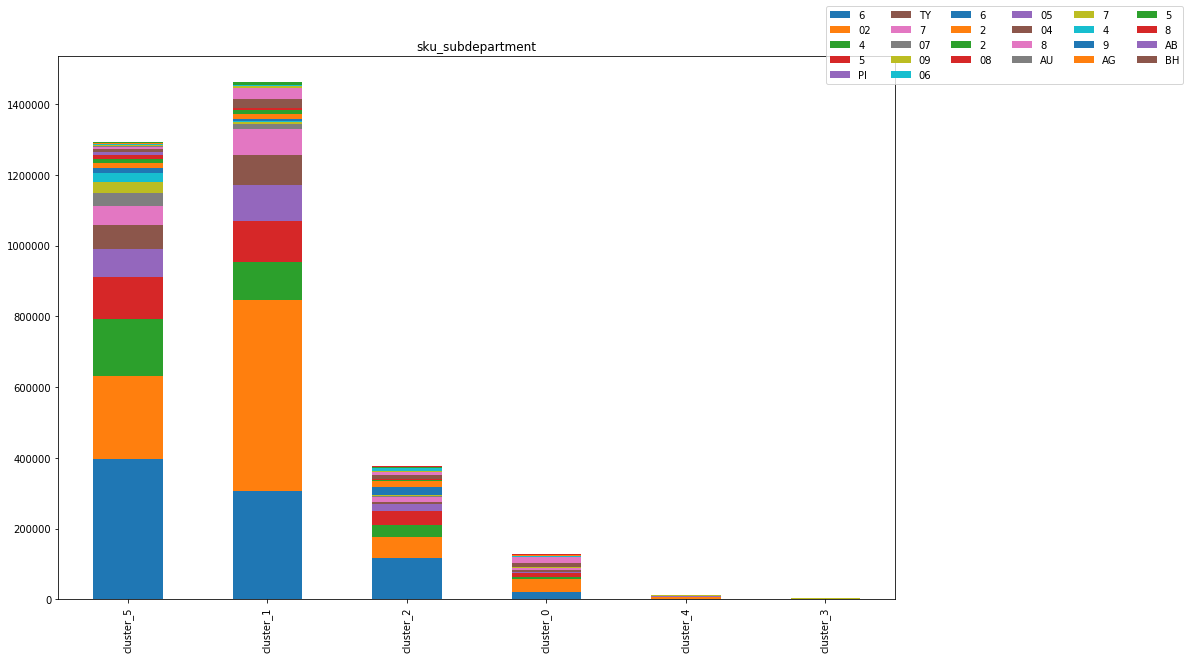



 sku_category


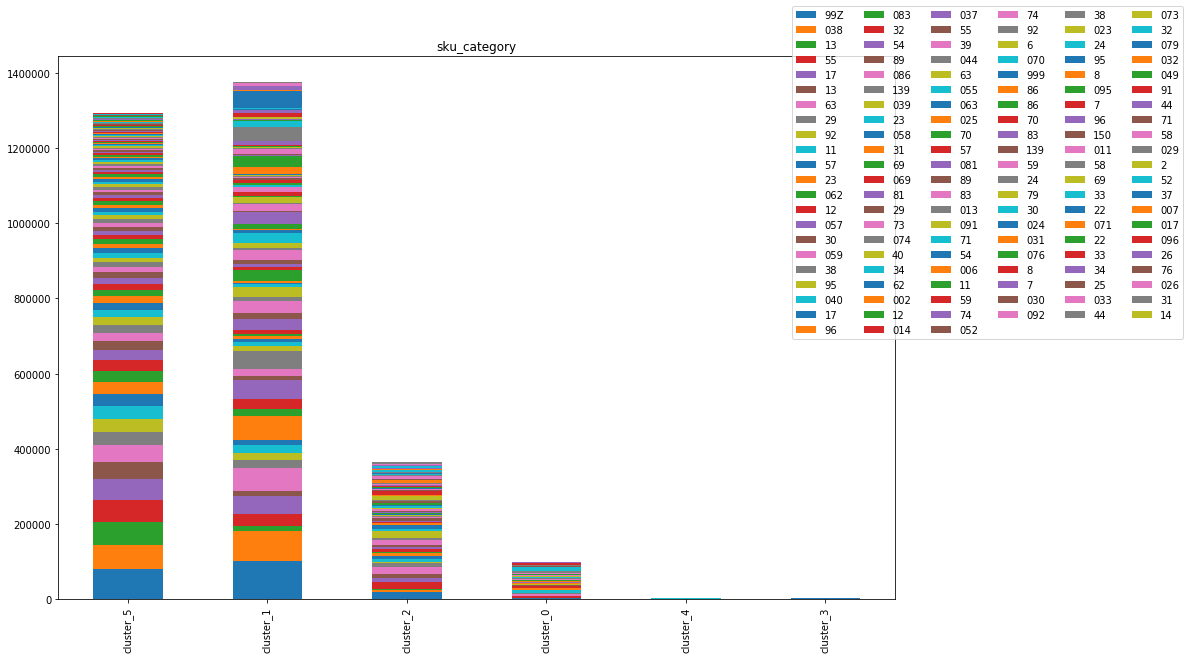



 sku_subcategory


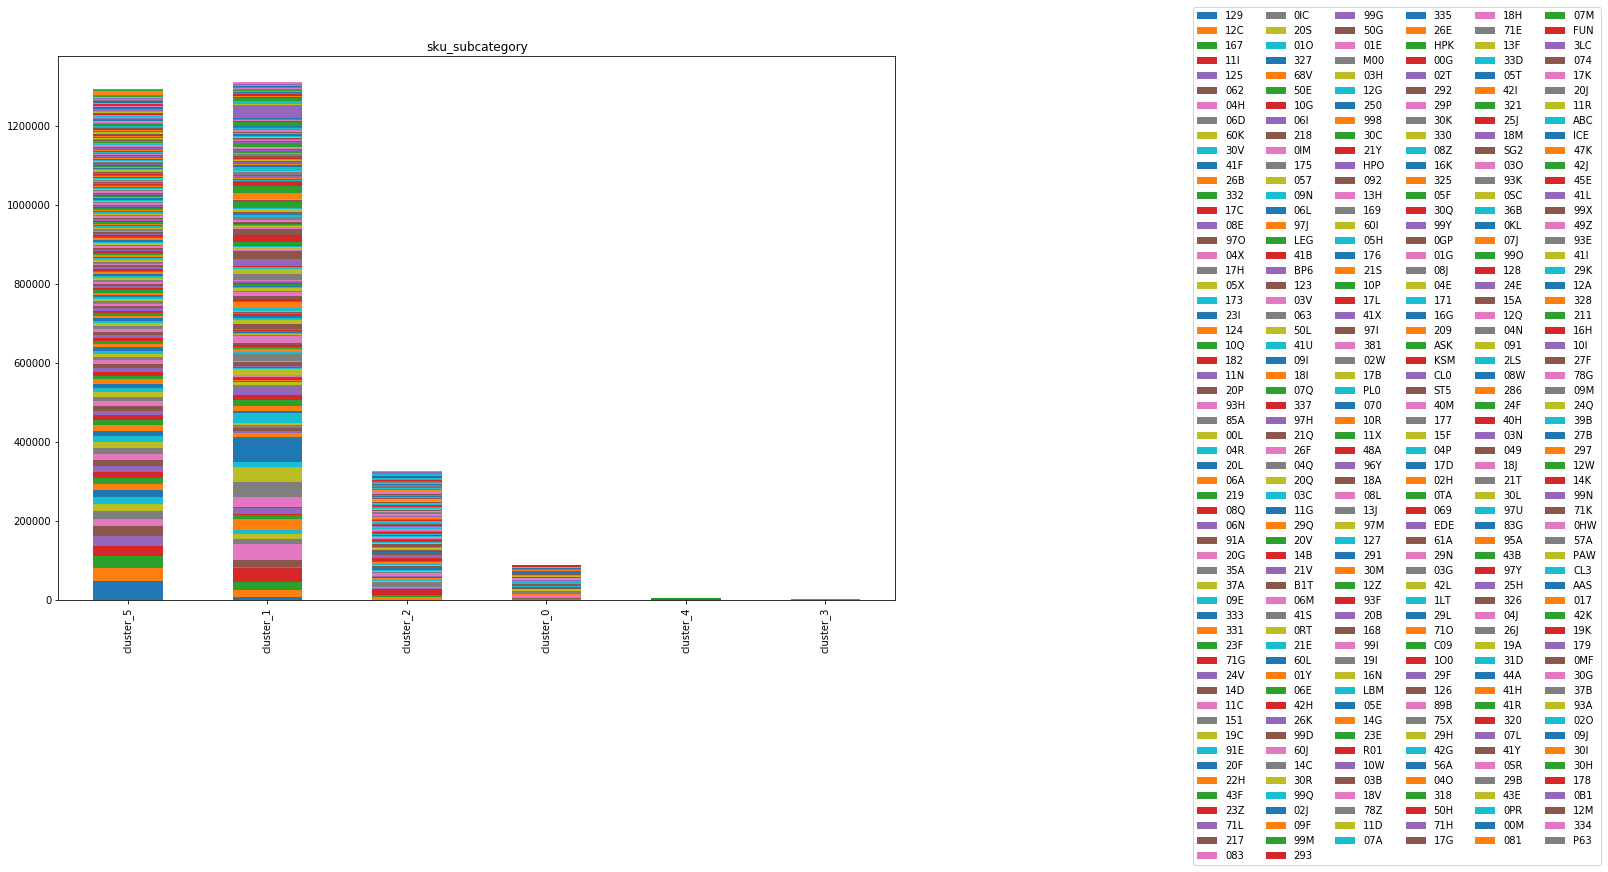



 sku_label


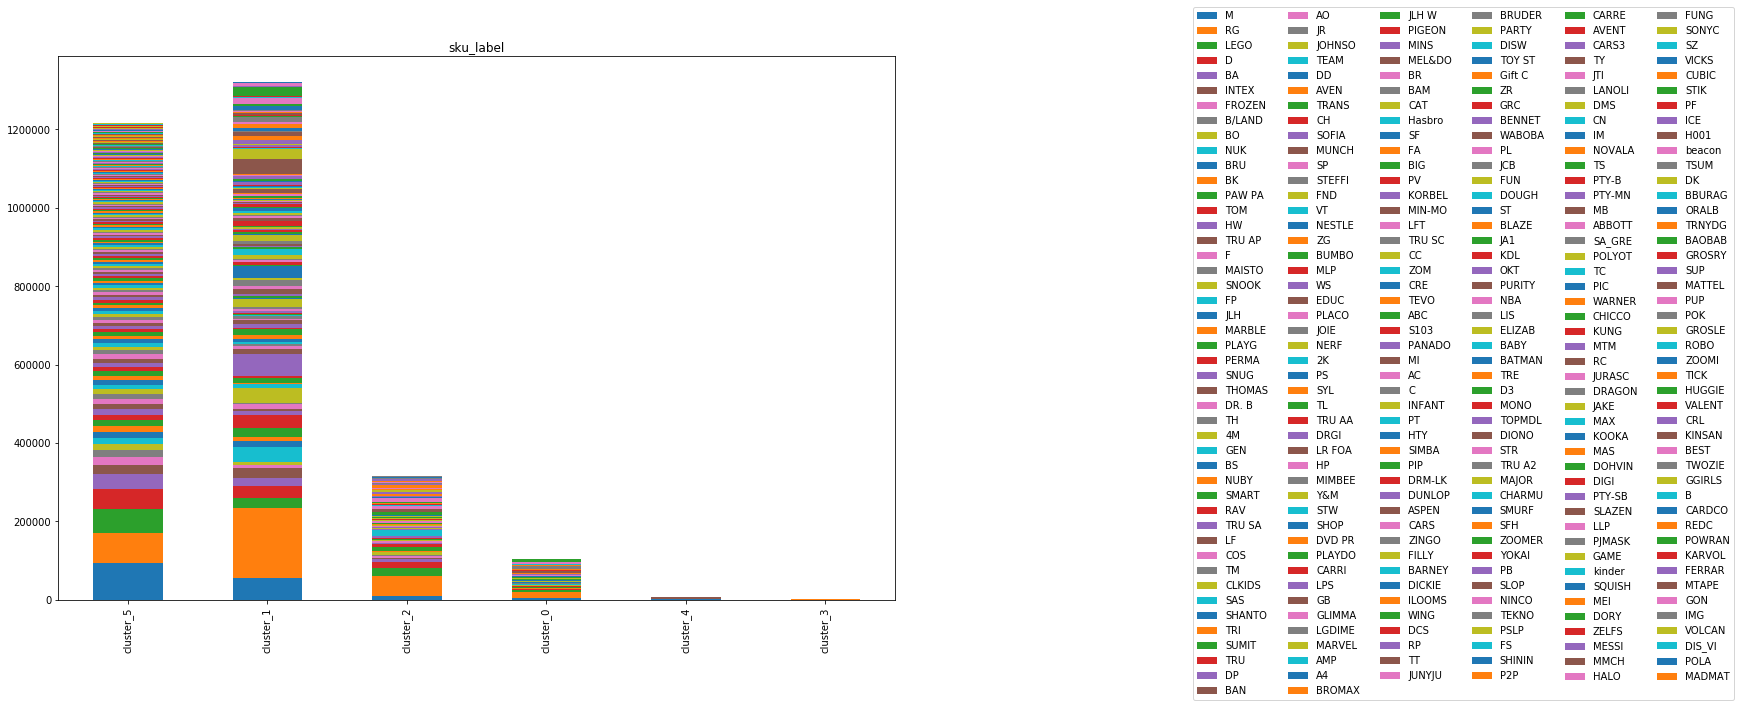

In [71]:
analyze_som.plot_cluster_categorical(df_dict, run_cats, True)

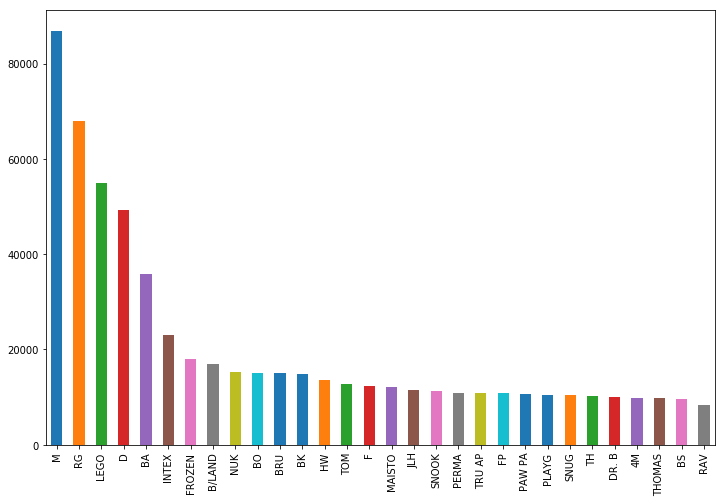

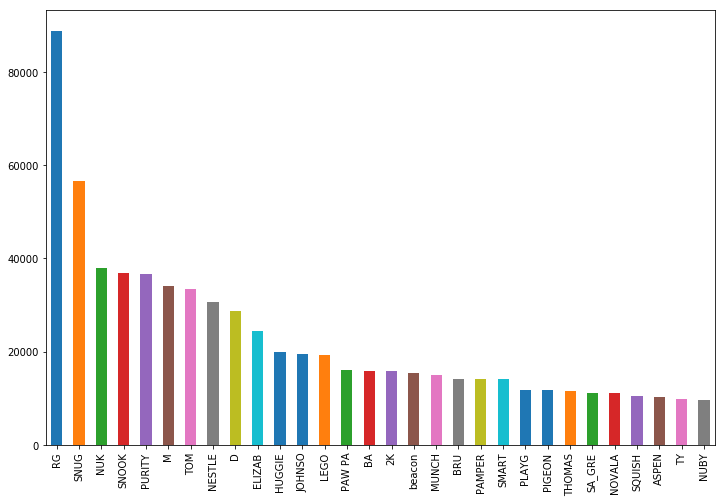

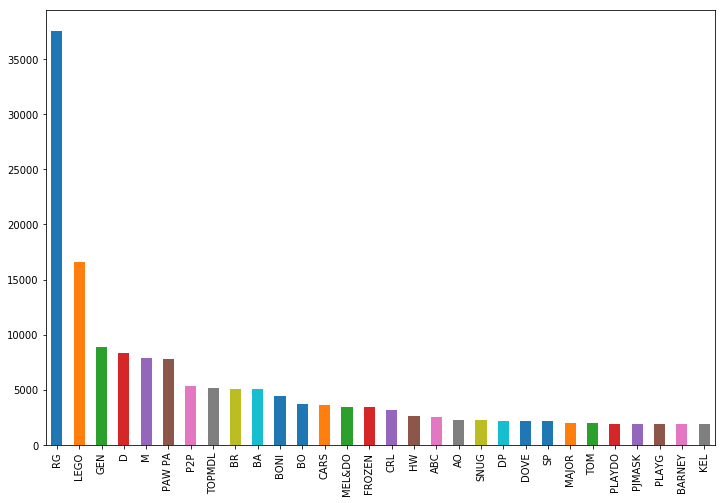

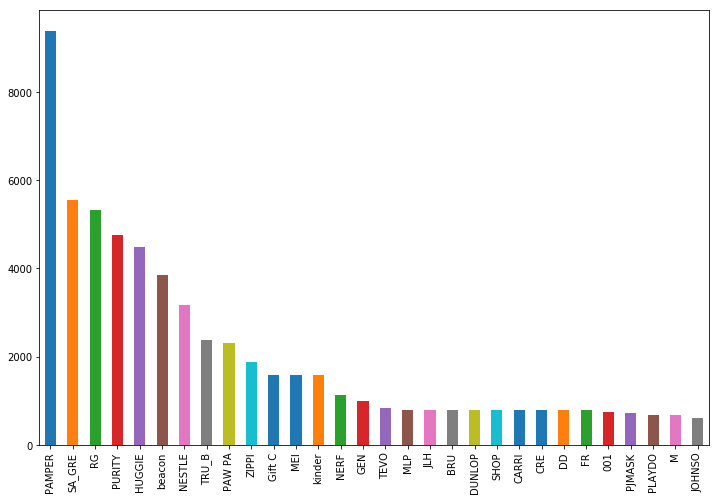

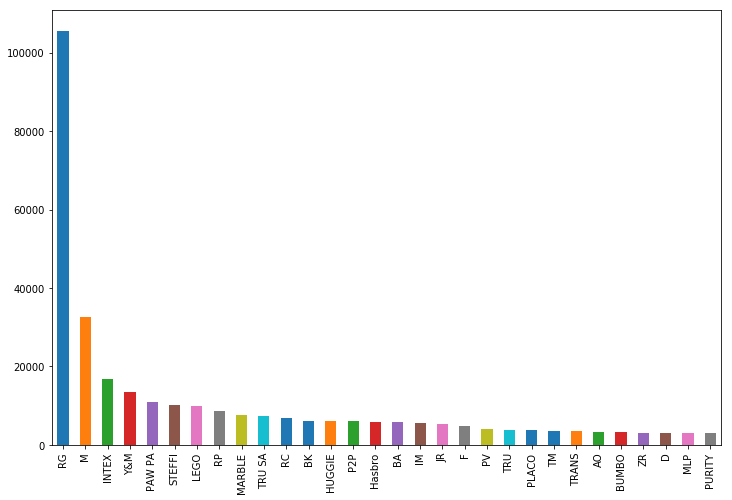

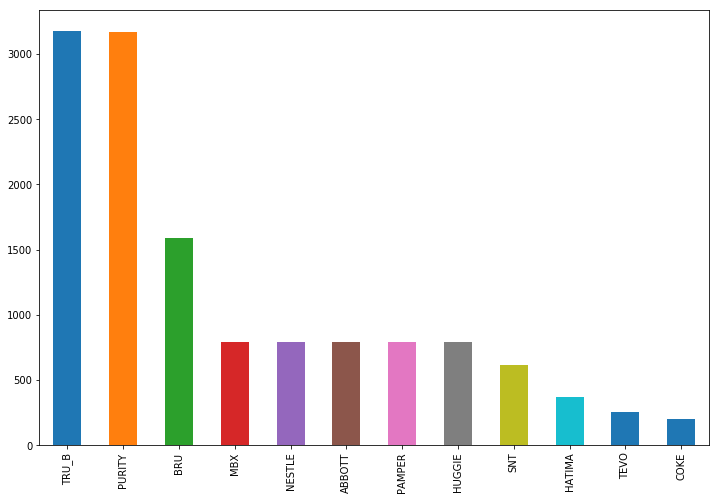

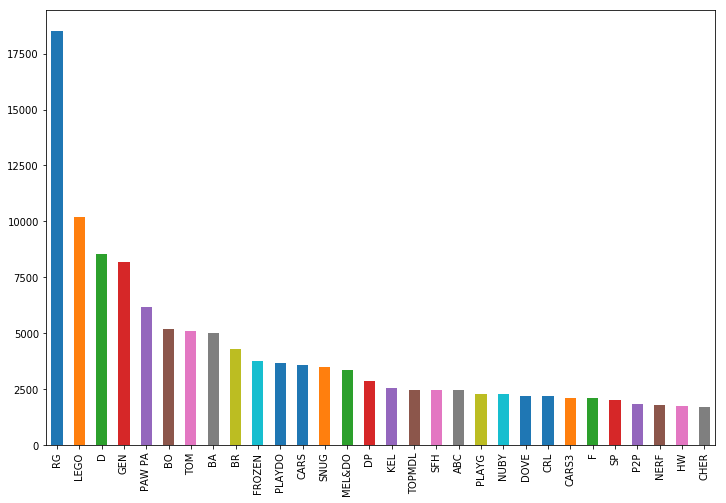

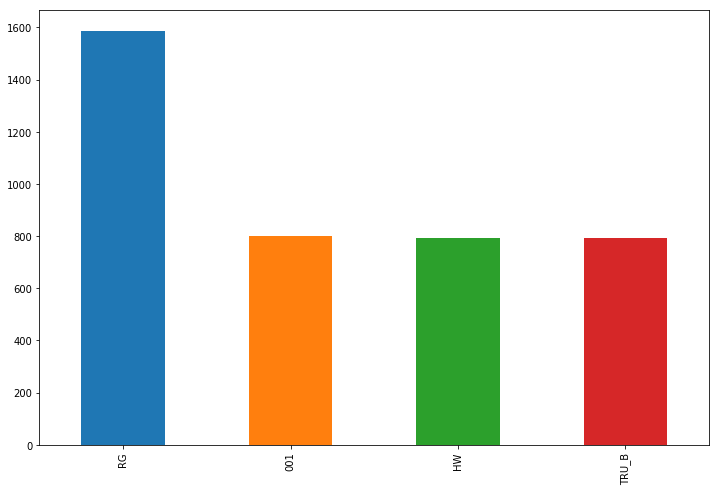

In [111]:
for i in df_dict.values():
    f = plt.figure(figsize=(12,8))
    i['sku_label'].value_counts()[:30].plot(kind='bar')
    plt.show()

Some messy inferential stats:

In [22]:
analyze_som.test_continuous_feat(df_dict, run_cont)


 
 sales
                sum_sq         df              F  PR(>F)
cluster   4.601521e+08        5.0  256994.180135     0.0
Residual  1.113149e+09  3108459.0            NaN     NaN 

   Multiple Comparison of Means - Tukey HSD,FWER=0.05   
  group1    group2   meandiff   lower     upper   reject
--------------------------------------------------------
cluster_0 cluster_1  -14.9012  -15.0595  -14.7429  True 
cluster_0 cluster_2  -15.7356  -15.9104  -15.5608  True 
cluster_0 cluster_3  291.7256  290.857   292.5942  True 
cluster_0 cluster_4  44.4828    43.992   44.9735   True 
cluster_0 cluster_5  -17.7939  -17.9522  -17.6356  True 
cluster_1 cluster_2  -0.8344   -0.9343   -0.7345   True 
cluster_1 cluster_3  306.6268  305.7702  307.4834  True 
cluster_1 cluster_4   59.384   58.9147   59.8533   True 
cluster_1 cluster_5  -2.8927   -2.9598   -2.8257   True 
cluster_2 cluster_3  307.4612  306.6013  308.321   True 
cluster_2 cluster_4  60.2183   59.7432   60.6934   True 
cluster_2 cluster_5

Now moving to cumulative sales per cluster

In [112]:
som_sales_df = sales_df.merge(som_clus, on='sku_key')
som_sales_df.head()

sku_key  sales          0         1  sales_log  cluster
0       28    122   9.399459 -3.136501   2.086360        5
1       34    794   9.616137  6.551555   2.899821        0
2      100   9186  10.934423  9.400847   3.963126        0
3      101     27   6.149228 -1.484529   1.431364        5
4      102    153   9.170244  2.053881   2.184691        5

cluster 5
1809


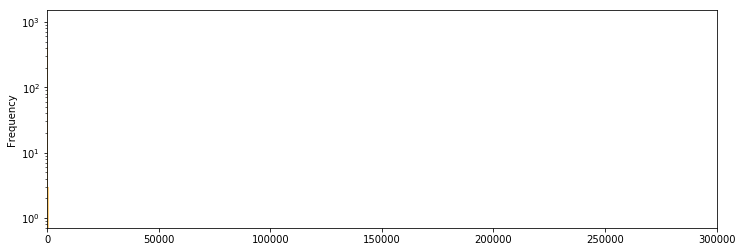

cluster 0
1538


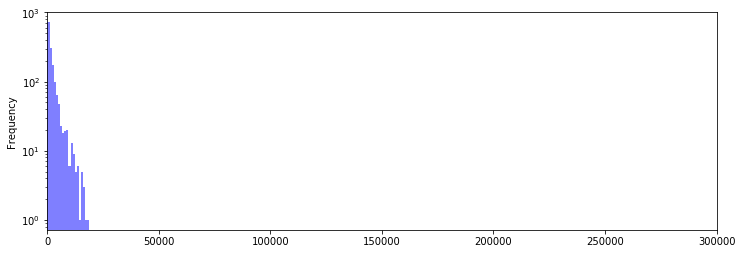

cluster 6
695


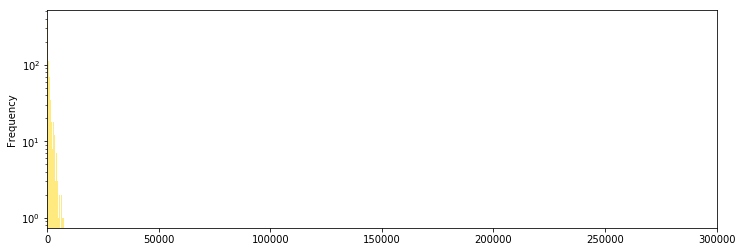

cluster 7
107


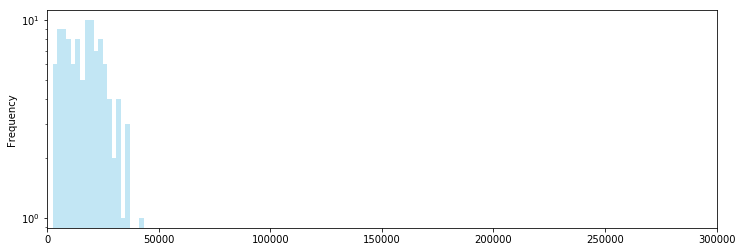

cluster 4
623


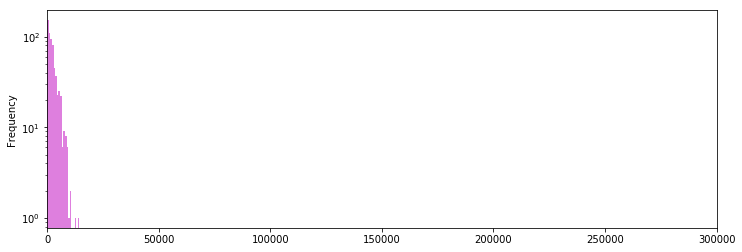

cluster 2
19


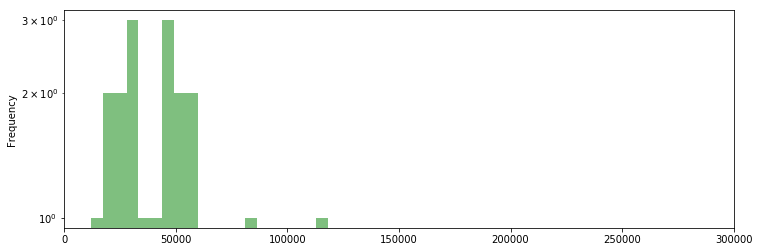

cluster 3
653


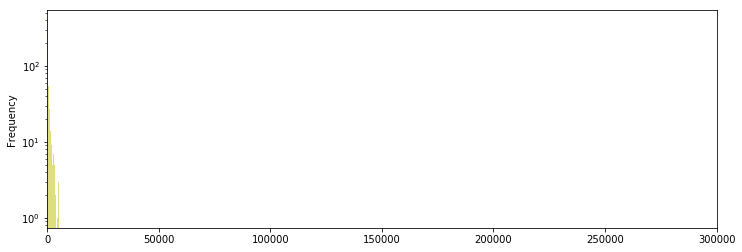

cluster 1
7


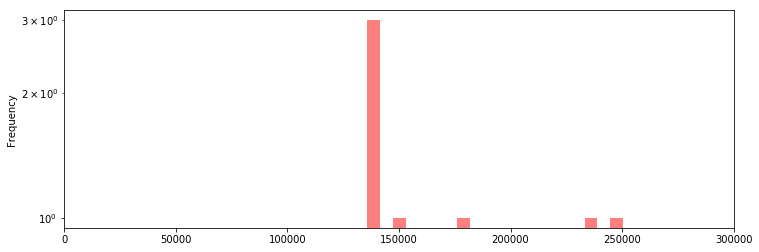

In [113]:
for i in som_sales_df['cluster'].unique():
    print('cluster {}'.format(i))
    print(len(som_sales_df[som_sales_df['cluster'] == i]['sales']))
    f, ax = plt.subplots(figsize=(12,4))
    som_sales_df[som_sales_df['cluster'] == i]['sales'].T.plot(kind='hist', color=colors[i], alpha=0.5, bins=20, ax=ax, logy=True)
    ax.set_xlim(-50, 300000)
    plt.show()

In [114]:
for a, i in enumerate(som_sales_df['cluster'].unique()):
    if a == 0:
        int_df = pd.DataFrame(som_sales_df[som_sales_df['cluster'] == i]['sales'])
        int_df.columns = [i]
    else:
        temp = pd.DataFrame(som_sales_df[som_sales_df['cluster'] == i]['sales'])
        temp.columns = [i]
        int_df = int_df.join(temp, how='outer')


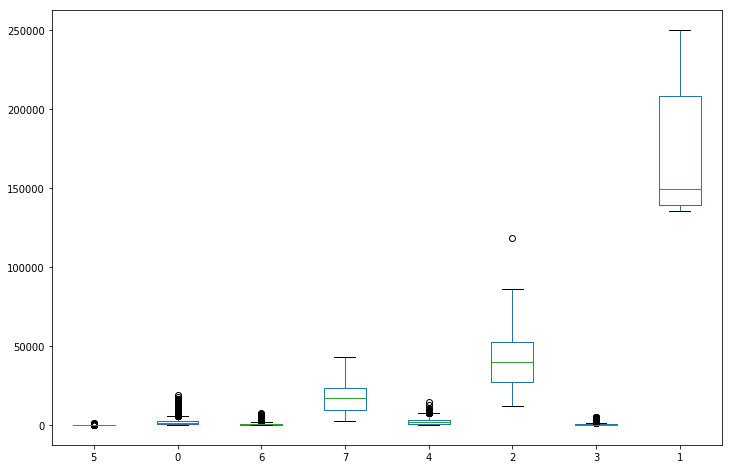

In [115]:
f, ax = plt.subplots(figsize=(12,8))
int_df.plot(kind='box', ax=ax)


In [33]:
int_df_unpiv = int_df.melt().dropna()
int_df_unpiv.columns = ['cluster', 'value']
int_df_unpiv.head()

cluster  value
0        5  122.0
3        5   27.0
4        5  153.0
5        5   35.0
7        5   89.0

In [34]:
mod = ols('value ~ cluster',
                data=int_df_unpiv).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)


                sum_sq      df           F        PR(>F)
cluster   7.895201e+09     1.0  134.284511  1.081467e-30
Residual  3.203716e+11  5449.0         NaN           NaN


In [35]:
print(pairwise_tukeyhsd(int_df_unpiv['value'], int_df_unpiv['cluster']))

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
group1 group2   meandiff      lower        upper     reject
-----------------------------------------------------------
  0      1     -9615.9309  -10301.0266   -8930.8351   True 
  0      2     -11111.756  -11816.7048  -10406.8071   True 
  0      3    164056.1591  160550.9322  167561.3859   True 
  0      4     32044.0087   29853.8271   34234.1902   True 
  0      5     -11693.107  -12377.8294  -11008.3846   True 
  1      2     -1495.8251   -1828.2779   -1163.3723   True 
  1      3    173672.0899  170222.4251  177121.7547   True 
  1      4     41659.9395   39559.8283   43760.0508   True 
  1      5     -2077.1761   -2364.2593   -1790.093    True 
  2      3     175167.915  171714.2526  178621.5774   True 
  2      4     43155.7646   41049.0933   45262.436    True 
  2      5      -581.351    -913.0338    -249.6683    True 
  3      4    -132012.1504 -136040.5156 -127983.7852  True 
  3      5    -175749.2661 -179198.8567 